In [ ]:
# !python -m spacy download en_core_web_md
# !python -m spacy download en_core_web_lg
# !python -m spacy download uk_core_news_sm
# !python -m spacy download uk_core_news_md
# !python -m spacy download uk_core_news_lg
# !python -m spacy download ru_core_news_sm
# !python -m spacy download ru_core_news_md
# !python -m spacy download ru_core_news_lg

In [286]:
import requests
import json
import pandas as pd
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import translators as ts          
from transliterate import translit, get_available_language_codes
import time
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output
import sqlite3
import ast
import re
import numpy as np
import gc
import string
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point
import time
import prettyprint as pp
from itertools import chain

import spacy
nlp = spacy.load('en_core_web_md')
import seaborn as sns
from multiprocessing import Pool, cpu_count

import translators as ts          
from transliterate import translit, get_available_language_codes

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

from fuzzywuzzy import fuzz as fuzzywuzz
from rapidfuzz import process, fuzz

from concurrent.futures import ThreadPoolExecutor

## June-Aug Processed Tweets

In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect(r'D:\PENNSTATE_GIS\CAPSTONE!\sql_db_lite\summer_2022_no_retweets_final.db')
query = """SELECT * from summer_2022_no_retweets_final LIMIT 5"""
tweets = pd.read_sql(query, conn)
conn.close()

In [2]:
def eval_if_list(x):
    if len(x) > 0:
        x = ast.literal_eval(x)
    else:
        pass
    return x

In [ ]:
tweets['places'] = tweets['places'].apply(lambda x: eval_if_list(x))
tweets['p_labels'] = tweets['p_labels'].apply(lambda x: eval_if_list(x))

In [ ]:
for col in ['coordinates', 'DATE', 'ORG', 'NORP', 'GPE', 'PERSON', 'TIME', 'CARDINAL', 'ORDINAL', 'PRODUCT', 'LOC', 'LANGUAGE', 'MONEY', 'FAC', 'EVENT', 'WORK_OF_ART', 'QUANTITY', 'LAW', 'PERCENT']:
    tweets[col] = tweets[col].apply(lambda x: eval_if_list(x))

In [ ]:
tweets.head()

## June-Aug Processed ACLED reports

In [3]:
# Connect to the SQLite database
conn = sqlite3.connect(r'D:\PENNSTATE_GIS\CAPSTONE!\sql_db_lite\ACLED_summer_2022_geo_ciw.db')
query = """SELECT * from ACLED_summer_2022_geo_ciw"""
acled_df = pd.read_sql(query, conn)
conn.close()
acled_df['GEONAMES_OSM'] = acled_df['GEONAMES_OSM'].apply(ast.literal_eval)
acled_df['STREETS'] = acled_df['STREETS'].apply(ast.literal_eval)
acled_df['CIW'] = acled_df['CIW'].apply(ast.literal_eval)

In [4]:
# Create a Point geometry for each point in the dataframe
geometry = [Point(xy) for xy in zip(acled_df['LONGITUDE'], acled_df['LATITUDE'])]

In [5]:
    # Create a GeoDataFrame from the dataframe and geometry
acled_gdf = gpd.GeoDataFrame(acled_df, geometry=geometry)

    # Set the coordinate reference system (CRS) of the GeoDataFrame
acled_gdf.crs = 'EPSG:4326'

    # Convert the buffer distance from kilometers to degrees
    # To buffer around a point with a 10-kilometer radius, you need to convert the distance from kilometers to degrees.
    # Buffer distance should be specified in the same unit as the CRS
buffer_distance_km = 10
buffer_distance_deg = buffer_distance_km / 111

acled_gdf['geometry'] = acled_gdf.geometry.buffer(buffer_distance_deg)

## August Events - Highest Count

In [6]:
acled_gdf['EVENT_DATE'] = pd.to_datetime(acled_gdf['EVENT_DATE'])

# Specify the date range
start_date = pd.to_datetime('2022-08-01')
end_date = pd.to_datetime('2022-08-15')

# Subset the dataframe based on the date range
acled_gdf = acled_gdf[(acled_gdf['EVENT_DATE'] >= start_date) & (acled_gdf['EVENT_DATE'] <= end_date)].reset_index(drop=True)
acled_gdf

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,...,SOURCE,SOURCE_SCALE,NOTES,FATALITIES,TIMESTAMP,MONTH,GEONAMES_OSM,CIW,STREETS,geometry
0,804,UKR66159,66159,2022-08-01,2022,1,Battles,Armed clash,NAF: United Armed Forces of Novorossiya,Donbass People's Militia; Military Forces of R...,...,Ministry of Defence of Ukraine; DPR Armed Forc...,Other,"On 1 August 2022, Russian forces shelled Zaits...",0,1660055880,8,"[Zajtseve, Gladosove, Dilіїvka, Druzhba, Pіvnі...","[zaitseve, day, tank, donetsk, mortar, positio...","[Radjans'koї Armії vulitsja, Fadєєva vulitsja,...","POLYGON ((38.09909 48.42900, 38.09866 48.42017..."
1,804,UKR66219,66219,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Russia (2000-),None,...,24 Channel; Ministry of Defence of Ukraine,Other-National,"On 1 August 2022, Russian forces fired artille...",1,1660055880,8,"[Harkіv - Nova Bavarіja, Novoselіvka, Unіversi...","[saltivskyi, bus, stop, city, district, hittin...","[Chkalova vulitsja, 1-j Chobotars'kij v’їzd, V...","POLYGON ((36.34309 49.98100, 36.34266 49.97217..."
2,804,UKR66494,66494,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Russia (2000-),None,...,Ministry of Defence of Ukraine; 24 Channel,Other-National,"On 1 August 2022, Russian forces shelled Mykol...",0,1660055880,8,"[Mikolaїv, Jakova Butovicha vulitsja, Ochakіvs...","[modern, trauma, center, including, hitting, t...","[Nіkol's'ka vulitsja, Odes'ke shose, Geroїv Uk...","POLYGON ((32.10809 46.96700, 32.10766 46.95817..."
3,804,UKR66904,66904,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Ukraine (2019-),None,...,DPR Armed Forces Press Service,Other,"On 1 August 2022, Ukrainian forces fired 120mm...",0,1660055880,8,"[Gorlіvka, Fedorіvka, Karlo-Marksove, Novoselі...","[bairak, mortar, position, dpr, fired, august,...","[Lugans'ke shose, Magіstral'na vulitsja, vulit...","POLYGON ((38.22209 48.31600, 38.22166 48.30717..."
4,804,UKR66905,66905,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Ukraine (2019-),None,...,DPR Armed Forces Press Service,Other,"On 1 August 2022, Ukrainian forces fired 155mm...",0,1660055880,8,"[Zajtseve, Gladosove, Svіtlodars'k, Lozove, Lu...","[dolomytne, mortar, position, dpr, fired, augu...","[Radjans'koї Armії vulitsja, Pershotravneva vu...","POLYGON ((38.22509 48.41600, 38.22466 48.40717..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,804,UKR77828,77828,2022-08-15,2022,3,Violence against civilians,Attack,Military Forces of Russia (2000-),None,...,Kharkiv Human Rights Protection Group,Other,"Around 15 August 2022 (month of), Russian forc...",0,1667319407,8,"[Pletenіvka, Tihe, Vovchans'kі Hutori, Pokalja...","[confinement, solitary, start, year, lyceum, v...","[Rubіzhans'ke shose, Privokzal'na vulitsja, Ob...","POLYGON ((37.03109 50.29100, 37.03066 50.28217..."
860,804,UKR78821,78821,2022-08-15,2022,3,Violence against civilians,Attack,Military Forces of Russia (2000-),None,...,HRW,Other,"Around 15 August 2022 (month of), Russian forc...",0,1667924775,8,"[368 km, Jahnichіv, Zabavne, Fedorіvka, Kramar...","[time, beat, released, illegally, detained, iz...","[Dzhona Lennona ploscha, Chumats'ka vulitsja, ...","POLYGON ((37.33809 49.20900, 37.33766 49.20017..."
861,804,UKR78820,78820,2022-08-15,2022,3,Violence against civilians,Attack,Military Forces of Russia (2000-),None,...,HRW,Other,"Around 15 August 2022 (month of), Russian forc...",1,1667924775,8,"[368 km, Jahnichіv, Zabavne, Fedorіvka, Kramar...","[central, later, police, illegally, detained, ...","[Dzhona Lennona ploscha, Chumats'ka vulitsja, ...","POLYGON ((37.33809 49.20900, 37.33766 49.20017..."
862,804,UKR78669,78669,2022-08-15,2022,3,Violence against civilians,Abduction/forced disappearance,Military Forces o

# Analysis

## Tweets with coords

In [365]:
tweets_with_coords = tweets[tweets['coordinates']!=''].reset_index(drop=True)
tweets_with_coords['LONGITUDE'] = [x[0] for x in tweets_with_coords['coordinates']]
tweets_with_coords['LATITUDE'] = [x[1] for x in tweets_with_coords['coordinates']]
tweets_with_coords

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,WORK_OF_ART,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90,MATCH_LOC,LONGITUDE,LATITUDE
0,Ypres,,,1553927957684666370,2022-08-01 02:17:50,0,#originalart #handmade #snow #ww1 #flanders ...,"[{'text': 'originalart', 'indices': [0, 12]}, ...","[2.88333, 50.85]",,...,,,,,"['originalart', 'handmade', 'snow', 'flanders'...",{},{},{},2.883330,50.850000
1,None,,,1554071677977235456,2022-08-01 11:48:55,1,Fire detected from #Sentinel2\n\n🗺 Place: Nady...,"[{'text': 'Sentinel2', 'indices': [19, 29]}, {...","[70.90026868, 64.73994989]",,...,,,,,"['fire', 'detected', 'place', 'nadymsky', 'dis...","{'fire': [512, 3, 4, 7, 520, 9, 10, 12, 526, 5...","{'fire': [802, 227, 164, 68, 580, 71, 803, 210...",{'russia': [704]},70.900269,64.739950
2,None,,,1554088636941041664,2022-08-01 12:56:19,42,Minister of Defense of Ukraine: 4 additional H...,"[{'text': 'Ukraine', 'indices': [121, 129]}]","[30.52914, 50.44426]",,...,,,,,"['minister', 'defense', 'ukraine', 'additional...","{'defense': [730], 'ukraine': [647], 'addition...","{'defense': [730], 'additional': [152, 613], '...",{'ukraine': [771]},30.529140,50.444260
3,None,,,1554126452794150912,2022-08-01 15:26:35,0,Fire detected from #Sentinel2\n\n🗺 Place: Dvor...,"[{'text': 'Sentinel2', 'indices': [19, 29]}, {...","[38.01321052, 49.94524939]",,...,,,,,"['fire', 'detected', 'place', 'dvorichanskyi',...","{'fire': [512, 3, 4, 7, 520, 9, 10, 12, 526, 5...","{'fire': [802, 227, 164, 68, 580, 71, 803, 210...",{'ukraine': [771]},38.013211,49.945249
4,None,,,1554127709705449474,2022-08-01 15:31:34,0,Fire detected from #Sentinel2\n\n🗺 Place: Azov...,"[{'text': 'Sentinel2', 'indices': [19, 29]}, {...","[38.90888781, 46.74300624]",,...,,,,,"['fire', 'detected', 'place', 'azovsky', 'dist...","{'fire': [512, 3, 4, 7, 520, 9, 10, 12, 526, 5...","{'fire': [802, 227, 164, 68, 580, 71, 803, 210...",{'russia': [704]},38.908888,46.743006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,Kyiv Ukraine,,,1558694536028856323,2022-08-14 05:58:31,0,"Weekend, 📷 by @motochyn \n.\n-\n#vocal #voice ...","[{'text': 'vocal', 'indices': [29, 35]}, {'tex...","[30.52361111, 50.45]",[weekend],...,,,,,"['weekend', 'vocal', 'voice', 'singing', 'meth...","{'vocal': [612, 229, 201], 'coach': [446], 'us...",{},{'london': [775]},30.523611,50.450000
156,"Tampa Bay, FL",['tampa bay'],['LOC'],1558872439173435392,2022-08-14 17:45:26,0,"Want to work at UPS? We're hiring in #Odessa, ...","[{'text': 'Odessa', 'indices': [37, 44]}, {'te...","[-82.578214, 28.1945035]",,...,,,,,"['want', 'work', 'ups', 'hiring', 'odessa', 'f...",{'work': [753]},{},{},-82.578214,28.194503
157,Worldwide,,,1558918077290491905,2022-08-14 20:46:47,0,Click the link in our bio to see currently ope...,"[{'text': 'Labor', 'indices': [48, 54]}, {'tex...","[-102.3676431, 31.8456816]",,...,,,,,"['click', 'link', 'bio', 'see', 'currently', '...","{'like': [481, 563, 436], 'part': [737, 565, 7...",{'time': [860]},{},-102.367643,31.845682
158,None,,,1558937716657491969,2022-08-14 22:04:49,0,Fire detected from #Sentinel2\n\n🗺 Place: Akht...,"[{'text': 'Sentinel2', 'indices': [19, 29]}, {...","[46.74468931, 47.88219338]",,...,,,,,"['fire', 'detected', 'place', 'akhtubinsky', '...","{'fire': [512, 3, 4, 7, 520, 9, 10, 12, 526, 5...","{'fire': [802, 227, 164, 68, 580, 71, 803, 210...",{'russia': [704]},46.744689,47.882193


### Tweets with coords that are w/in 10km of an ACLED reported location

In [366]:
    # Create a new 'geometry' column in the DataFrame with Point objects
tweets_with_coords['geometry'] = [Point(lon, lat) for lon, lat in zip(tweets_with_coords['LONGITUDE'], tweets_with_coords['LATITUDE'])]
    # Convert the DataFrame to a GeoDataFrame
tweets_with_coords = gpd.GeoDataFrame(tweets_with_coords, geometry='geometry')
tweets_with_coords.crs = 'EPSG:4326'

We use the 'index_right' column to create a mask ('within_mask') to identify the points that fell within a polygon. Then, we use this mask to extract the 'EVENT_DATE' column from 'acled_gdf' for the matching points and assign it to the corresponding rows in 'tweets_near_events'. This way, only points that fell within a polygon will have the 'EVENT_DATE' associated with that polygon, and the others will have NaN in the 'EVENT_DATE' column.

After this, we drop the 'index_right' column (if you don't need it) and reset the index to have a clean DataFrame with the desired information. Now, 'tweets_near_events' should contain all the records from 'tweets_with_coords', and if a point fell within a polygon, it includes the 'EVENT_DATE' associated with that polygon in a new column.

In [367]:
tweets_near_events = gpd.sjoin(tweets_with_coords, acled_gdf, how='left', op='within')

# Create a mask to identify points that fell within a polygon
within_mask = tweets_near_events['index_right'].notna()

# Extract the 'EVENT_DATE' column from 'acled_gdf' for the matching points
tweets_near_events.loc[within_mask, 'EVENT_DATE'] = acled_gdf.loc[tweets_near_events.loc[within_mask, 'index_right'], 'EVENT_DATE'].values

# Drop the 'index_right' column and reset the index
tweets_near_events = tweets_near_events.drop(columns='index_right').reset_index(drop=True)

# 'tweets_near_events' now contains all records from 'tweets_with_coords' and includes the 'EVENT_DATE' column
# from 'acled_gdf' for points that fell within the corresponding polygons.

In [372]:
tweets_near_events = tweets_near_events[['location', 'places', 'p_labels', 'tweetid', 'tweetcreatedts',
       'retweetcount', 'text', 'hashtags', 'coordinates', 'DATE', 'ORG',
       'NORP', 'GPE', 'PERSON', 'TIME', 'CARDINAL', 'ORDINAL', 'PRODUCT',
       'LOC', 'LANGUAGE', 'MONEY', 'FAC', 'EVENT', 'WORK_OF_ART', 'QUANTITY',
       'LAW', 'PERCENT', 'TEXT_PROCESSED', 'MATCH_CIW', 'MATCH_CIW_90',
       'MATCH_LOC', 'geometry', 'EVENT_DATE', 'NOTES']]

In [322]:
# %%time
# # Check if each point is within any polygon
# within_mask = tweets_with_coords.geometry.within(acled_gdf.unary_union)

# # Subset the DataFrame to include only the points within polygons
# tweets_near_events = tweets_with_coords[within_mask].reset_index(drop=True)
# tweets_near_events

## Set up Matching Strategy

- Unlike partial matching, fuzzy matching can handle more complex token differences, such as transpositions, insertions, or deletions, by assigning similarity scores or distances.

In [98]:
def preprocess_tweet(tweet):
    # Make the tweet lowercase
    tweet = tweet.lower()
    
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    
#     #remove text in square brackets
#     tweet = re.sub(r'\[.*?\]', '', tweet)
    
    # Remove punctuation
    tweet = re.sub(r'[^\w\s]', '', tweet)
    
    # Remove Emojis
    tweet = tweet.encode('ascii', 'ignore').decode('ascii')

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    
    # Tokenization
    tokens = word_tokenize(tweet)
    filtered_tweet = [i for i in tokens if not i in stop_words]
    
    # Remove digits and words with digits
    filtered_tweet = [i for i in filtered_tweet if not any(j.isdigit() for j in i)]

#     # Joining back the list of words to form a processed tweet
#     tweet = ' '.join(filtered_tweet)

    return filtered_tweet

In [178]:
def get_place_names(text):
    # Process the text
    doc = nlp(text)
    
    # Get the place names
    place_names = [ent.text for ent in doc.ents if ent.label_ in ['GPE', 'LOC']] #FAC', 'LOC
    
    return place_names

In [179]:
def preprocess_places(place_list):
    cleaned_list = []
    for p in place_list:
        # Make the tweet lowercase
        text = p.lower()

        # Remove urls
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

        # Remove user @ references and '#' from tweet
        text = re.sub(r'\@\w+|\#','', text)

    #     #remove text in square brackets
    #     text = re.sub(r'\[.*?\]', '', text)

    #     # Remove punctuation
    #     text = re.sub(r'[^\w\s]', '', text)

        # Remove Emojis
        text = text.encode('ascii', 'ignore').decode('ascii')

        extra_stopwords = ['vulitsja']
        all_stopwords = stopwords.words('english') + extra_stopwords # Removing Ukranian word for street

        # Remove stopwords
        stop_words = set(all_stopwords) 

        # Tokenization
        tokens = word_tokenize(text)
        filtered_text = [i for i in tokens if not i in stop_words]

        # Remove digits and words with digits
        filtered_text = [i for i in filtered_text if not any(j.isdigit() for j in i)]
        
                # Joining back the list of words to form a processed text
#         text = ' '.join(filtered_text)
        
        text = ' '.join(filtered_text)
        place_names = get_place_names(text)
        
        cleaned_list.append(place_names)
        
    return cleaned_list

### Clean Gazetteer places - Includes NER for GPE and LOC

In [182]:
%%time
acled_gdf['CLEANED_PLACES'] = acled_gdf['COMBINED_PLACES'].apply(lambda x: preprocess_places(x))

Wall time: 1h 6min 56s


In [200]:
acled_gdf['CLEANED_PLACES'] = acled_gdf['CLEANED_PLACES'].apply(lambda x: list(chain(*x)) if x else [])

In [205]:
acled_gdf['CLEANED_PLACES'] = acled_gdf['CLEANED_PLACES'].apply(lambda x: list(set(x)))

In [206]:
acled_gdf

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,...,NOTES,FATALITIES,TIMESTAMP,MONTH,GEONAMES_OSM,CIW,STREETS,geometry,COMBINED_PLACES,CLEANED_PLACES
0,804,UKR66159,66159,2022-08-01,2022,1,Battles,Armed clash,NAF: United Armed Forces of Novorossiya,Donbass People's Militia; Military Forces of R...,...,"On 1 August 2022, Russian forces shelled Zaits...",0,1660055880,8,"[Zajtseve, Gladosove, Dilіїvka, Druzhba, Pіvnі...","[zaitseve, tank, donetsk, mortar]","[Radjans'koї Armії vulitsja, Fadєєva vulitsja,...","POLYGON ((38.09909 48.42900, 38.09866 48.42017...","[Zajtseve, Gladosove, Dilіїvka, Druzhba, Pіvnі...","[transformatorna, nalivna, shahtna, osnnja, po..."
1,804,UKR66219,66219,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Russia (2000-),None,...,"On 1 August 2022, Russian forces fired artille...",1,1660055880,8,"[Harkіv - Nova Bavarіja, Novoselіvka, Unіversi...","[saltivskyi, bus, stop, city, district]","[Chkalova vulitsja, 1-j Chobotars'kij v’їzd, V...","POLYGON ((36.34309 49.98100, 36.34266 49.97217...","[Harkіv - Nova Bavarіja, Novoselіvka, Unіversi...","[veterinarna, muzkomed, flja, dinamo, junatstv..."
2,804,UKR66494,66494,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Russia (2000-),None,...,"On 1 August 2022, Russian forces shelled Mykol...",0,1660055880,8,"[Mikolaїv, Jakova Butovicha vulitsja, Ochakіvs...","[modern, trauma, center, including, hitting]","[Nіkol's'ka vulitsja, Odes'ke shose, Geroїv Uk...","POLYGON ((32.10809 46.96700, 32.10766 46.95817...","[Mikolaїv, Jakova Butovicha vulitsja, Ochakіvs...","[dinamo, o.v ., brigadi, apel'sin, zolote, zho..."
3,804,UKR66904,66904,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Ukraine (2019-),None,...,"On 1 August 2022, Ukrainian forces fired 120mm...",0,1660055880,8,"[Gorlіvka, Fedorіvka, Karlo-Marksove, Novoselі...","[bairak, mortar, position, dpr, fired]","[Lugans'ke shose, Magіstral'na vulitsja, vulit...","POLYGON ((38.22209 48.31600, 38.22166 48.30717...","[Gorlіvka, Fedorіvka, Karlo-Marksove, Novoselі...","[vl'gel'ma, junatstva, jablochkno, apel'sin, n..."
4,804,UKR66905,66905,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Ukraine (2019-),None,...,"On 1 August 2022, Ukrainian forces fired 155mm...",0,1660055880,8,"[Zajtseve, Gladosove, Svіtlodars'k, Lozove, Lu...","[dolomytne, mortar, position, dpr, fired]","[Radjans'koї Armії vulitsja, Pershotravneva vu...","POLYGON ((38.22509 48.41600, 38.22466 48.40717...","[Zajtseve, Gladosove, Svіtlodars'k, Lozove, Lu...","[vl'gel'ma, nalivna, baksheva, nova, mazaja, k..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,804,UKR77828,77828,2022-08-15,2022,3,Violence against civilians,Attack,Military Forces of Russia (2000-),None,...,"Around 15 August 2022 (month of), Russian forc...",0,1667319407,8,"[Pletenіvka, Tihe, Vovchans'kі Hutori, Pokalja...","[confinement, solitary, start, year, lyceum]","[Rubіzhans'ke shose, Privokzal'na vulitsja, Ob...","POLYGON ((37.03109 50.29100, 37.03066 50.28217...","[Pletenіvka, Tihe, Vovchans'kі Hutori, Pokalja...","[veterinarna, rtps, zavgorodnja, siminvka, kl'..."
860,804,UKR78821,78821,2022-08-15,2022,3,Violence against civilians,Attack,Military Forces of Russia (2000-),None,...,"Around 15 August 2022 (month of), Russian forc...",0,1667924775,8,"[368 km, Jahnichіv, Zabavne, Fedorіvka, Kramar...","[time, beat, released, illegally, detained]","[Dzhona Lennona ploscha, Chumats'ka vulitsja, ...","POLYGON ((37.33809 49.20900, 37.33766 49.20017...","[368 km, Jahnichіv, Zabavne, Fedorіvka, Kramar...","[tolbuhna, shokolad, korovjachij, laboratorja,..."
861,804,UKR78820,78820,2022-08-15,2022,3,Violence against civilians,Attack,Military Forces of Russia (2000-),None,...,"Around 15 August 2022 

### Process tweets

In [ ]:
tweets_near_events['TEXT_PROCESSED'] = tweets_near_events['text'].apply(lambda x: preprocess_tweet(x))

### Process tweets ALL tweets

In [ ]:
tweets['TEXT_PROCESSED'] = tweets['text'].apply(lambda x: preprocess_tweet(x))
tweets.head()

### Process ACLED

In [8]:
# Function to append word string into the list
def append_string(row):
    row['GEONAMES_OSM'].append(row['LOCATION'])
    return row

# Apply the function to each row
acled_gdf = acled_gdf.apply(append_string, axis=1)

In [9]:
# Function to combine lists from each row
def combine_lists(row):
    return row['GEONAMES_OSM'] + row['STREETS']

acled_gdf['COMBINED_PLACES'] = acled_gdf.apply(combine_lists, axis=1)

In [10]:
    # Truncating the CIW lists
acled_gdf['CIW'] = acled_gdf['CIW'].apply(lambda x: x[0:5])
    # Removing "stop-words"
stopwords = ['force', 'unknown', 'russian', 'june', 'july', 'august', 'ukrainian', 'wa', 'night', 'people', 'day', 'russia', 'region', 'food', 'today', 'new']
acled_gdf['CIW'] = acled_gdf['CIW'].apply(lambda x: [word for word in x if word not in stopwords])

In [11]:
    # Average length of 10km surrounding names from PLACE lists
sum([len(l) for l in acled_gdf['COMBINED_PLACES'].to_list()]) / len(acled_gdf['COMBINED_PLACES'])

1402.5208333333333

In [207]:
acled_gdf.head()

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,...,NOTES,FATALITIES,TIMESTAMP,MONTH,GEONAMES_OSM,CIW,STREETS,geometry,COMBINED_PLACES,CLEANED_PLACES
0,804,UKR66159,66159,2022-08-01,2022,1,Battles,Armed clash,NAF: United Armed Forces of Novorossiya,Donbass People's Militia; Military Forces of R...,...,"On 1 August 2022, Russian forces shelled Zaits...",0,1660055880,8,"[Zajtseve, Gladosove, Dilіїvka, Druzhba, Pіvnі...","[zaitseve, tank, donetsk, mortar]","[Radjans'koї Armії vulitsja, Fadєєva vulitsja,...","POLYGON ((38.09909 48.42900, 38.09866 48.42017...","[Zajtseve, Gladosove, Dilіїvka, Druzhba, Pіvnі...","[transformatorna, nalivna, shahtna, osnnja, po..."
1,804,UKR66219,66219,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Russia (2000-),None,...,"On 1 August 2022, Russian forces fired artille...",1,1660055880,8,"[Harkіv - Nova Bavarіja, Novoselіvka, Unіversi...","[saltivskyi, bus, stop, city, district]","[Chkalova vulitsja, 1-j Chobotars'kij v’їzd, V...","POLYGON ((36.34309 49.98100, 36.34266 49.97217...","[Harkіv - Nova Bavarіja, Novoselіvka, Unіversi...","[veterinarna, muzkomed, flja, dinamo, junatstv..."
2,804,UKR66494,66494,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Russia (2000-),None,...,"On 1 August 2022, Russian forces shelled Mykol...",0,1660055880,8,"[Mikolaїv, Jakova Butovicha vulitsja, Ochakіvs...","[modern, trauma, center, including, hitting]","[Nіkol's'ka vulitsja, Odes'ke shose, Geroїv Uk...","POLYGON ((32.10809 46.96700, 32.10766 46.95817...","[Mikolaїv, Jakova Butovicha vulitsja, Ochakіvs...","[dinamo, o.v ., brigadi, apel'sin, zolote, zho..."
3,804,UKR66904,66904,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Ukraine (2019-),None,...,"On 1 August 2022, Ukrainian forces fired 120mm...",0,1660055880,8,"[Gorlіvka, Fedorіvka, Karlo-Marksove, Novoselі...","[bairak, mortar, position, dpr, fired]","[Lugans'ke shose, Magіstral'na vulitsja, vulit...","POLYGON ((38.22209 48.31600, 38.22166 48.30717...","[Gorlіvka, Fedorіvka, Karlo-Marksove, Novoselі...","[vl'gel'ma, junatstva, jablochkno, apel'sin, n..."
4,804,UKR66905,66905,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Ukraine (2019-),None,...,"On 1 August 2022, Ukrainian forces fired 155mm...",0,1660055880,8,"[Zajtseve, Gladosove, Svіtlodars'k, Lozove, Lu...","[dolomytne, mortar, position, dpr, fired]","[Radjans'koї Armії vulitsja, Pershotravneva vu...","POLYGON ((38.22509 48.41600, 38.22466 48.40717...","[Zajtseve, Gladosove, Svіtlodars'k, Lozove, Lu...","[vl'gel'ma, nalivna, baksheva, nova, mazaja, k..."


### How do I know what 'CIW' matches are considered "relevant"?
- Only 7 out of 5107 CIW lists has 'russia' in the first 5 TF-IDF scored words. Two in the first 3.
- 476 out of 5107 CIW lists has 'russian' in the first 5 TF-IDF scored words. Zero in the first 3.
* To avoid falsely associating a tweet with dozens of conflict events, simply because the word Russia, or similiar comomon words are in the reports, it may be nescessary to truncate the CIW lists to 3-5 words.
- Likely need to remove words with the highest mean TF-IDF score between all documents, considered common "stop-words" for ALCED reports, such as "russian" and "ukrainian".

In [209]:
df1 = tweets.iloc[0:10]
df2 = acled_gdf.copy()
    # Truncating the CIW lists
df2['CIW'] = df2['CIW'].apply(lambda x: x[0:5])
    # Removing "stop-words"
stopwords = ['force', 'unknown', 'russian', 'june', 'july', 'august', 'ukrainian', 'wa', 'night', 'people', 'day', 'russia', 'regions', 'food']
df2['CIW'] = df2['CIW'].apply(lambda x: [word for word in x if word not in stopwords])

### NLP matching strategy - Fuzzy Match - Levenshtein distance formula

In [28]:
def conduct_rapidfuzz_matching(df1, df2, column_to_compare, match_field, threshold):
    # Create a dictionary of word-to-index mappings for the second DataFrame
    word_index_dict = {}
    for index, words_list in enumerate(df2[column_to_compare]):
        for word in set(words_list):  # Use set to get unique words within each list
            if word not in word_index_dict:
                word_index_dict[word] = []
            word_index_dict[word].append(index)

    # Fuzzy matching function
    def fuzzy_match_strings(token, words_list):
        matches = set()  # Use a set to store unique indices
        for index, word_list in enumerate(words_list):
            for word in set(word_list):  # Use set to get unique words within each list
                score = fuzz.token_sort_ratio(token, word)
                if score >= threshold:
                    matches.update(word_index_dict[word])  # Update with all corresponding indices
#                     print(f"Token '{token}' matched with word '{word}'")
                    break  # Skip further matching on the word
        return list(matches)  # Convert set to a list

    # Modify the original DataFrame
    df1[match_field] = df1['TEXT_PROCESSED'].apply(lambda tokens_list: {
        token: fuzzy_match_strings(token, df2[column_to_compare])
        for token in tokens_list
        if fuzzy_match_strings(token, df2[column_to_compare])
    })

    return df1

In [247]:
def conduct_matching(df1, df2, column_to_compare, match_field):
    # Create a dictionary of word-to-index mappings for the second DataFrame
    word_index_dict = {word: index for index, words_list in enumerate(df2[column_to_compare]) for word in words_list}

    # Matching function
    def match_strings(token, words_list):
        matches = set()  # Use a set to store unique indices
        for index, word_list in enumerate(words_list):
            for word in word_list:
                if token == word:
                    matches.add(word_index_dict[word])
                    break
#                 elif token in word:
#                     matches.add(word_index_dict[word])
        return list(matches)  # Convert set to a list

    # Modify the original DataFrame
    df1[match_field] = df1['TEXT_PROCESSED'].apply(lambda tokens_list: {
        token: match_strings(token, df2[column_to_compare])
        for token in tokens_list
        if match_strings(token, df2[column_to_compare])
    })

    return df1

In [230]:
# def calculate_jaccard_similarity(token, word):
#     token_set = set(token)
#     word_set = set(word)
#     intersection = len(token_set.intersection(word_set))
#     union = len(token_set) + len(word_set) - intersection
#     return intersection / union if union != 0 else 0.0

In [231]:
# def conduct_matching(df1, df2, column_to_compare, match_field, threshold):
#     # Create a dictionary of word-to-index mappings for the second DataFrame
#     word_index_dict = {word: index for index, words_list in enumerate(df2[column_to_compare]) for word in words_list}

#     # Matching function
#     def match_strings(token, words_list):
#         matches = set()  # Use a set to store unique indices
#         for index, word_list in enumerate(words_list):
#             for word in word_list:
#                 similarity = calculate_jaccard_similarity(token, word)
#                 if similarity >= threshold:
#                     matches.add(word_index_dict[word])
#         return list(matches)  # Convert set to a list

#     # Modify the original DataFrame
#     df1[match_field] = df1['TEXT_PROCESSED'].apply(lambda tokens_list: {
#         token: match_strings(token, df2[column_to_compare])
#         for token in tokens_list
#         if match_strings(token, df2[column_to_compare])
#     })

#     return df1

#### For fuzzywuzzy 1 min 18 sec for 10 by 10
- If the threshold is set to 80, it will match words like person to Perron, or region with Legion
- If the threshold is set to 85, it still matches words like shot to Shoti, but misses shostka with Sotka
- If the threshold is set to 90, at least 2/3 of matches appear to be actual place names

#### For rapidfuzz  2.5 sec for 10 by 10
- A threshold of 80 is comparable to 90 for fuzzywuzzy

##### Testing

In [32]:
%%time
df_matches = conduct_rapidfuzz_matching(df1, df2, 'COMBINED_PLACES', 'MATCH_LOC', 90)
df_matches

Wall time: 1min 39s


,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,FAC,EVENT,WORK_OF_ART,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90,MATCH_LOC
0,None,,,1553893274687094785,2022-08-01 00:00:01,0,"Hi #NATO , you have to understand that we are ...","[{'text': 'NATO', 'indices': [3, 8]}]",,,...,,,,,,,"[hi, nato, understand, billions, cant, fight, ...","{'hi': [359, 472, 681, 298, 554, 689, 341, 152...","{'population': [748, 183]}",{}
1,"Melbourne, Australia",[],[],1553893276297891840,2022-08-01 00:00:01,0,Owner of Ukraine's largest grain exporter kill...,"[{'text': 'UkraineInvasion', 'indices': [100, ...",,,...,,,,,,,"[owner, ukraines, largest, grain, exporter, ki...","{'owner': [425, 686, 208, 753, 214, 762, 155],...","{'grain': [231], 'killed': [389, 392, 418, 432...",{}
2,Ukraine,,,1553893276306051075,2022-08-01 00:00:01,2,"Animal shelter Dogs and Cats, we need your hel...","[{'text': 'Ukraine', 'indices': [189, 197]}, {...",,,...,,,,,,,"[animal, shelter, dogs, cats, need, help, rais...","{'food': [760], 'ukraine': [647]}",{},{}
3,None,,,1553893278575198209,2022-08-01 00:00:02,1,Why #Iran-#Russia relations likely won’t go be...,"[{'text': 'Iran', 'indices': [4, 9]}, {'text':...",,,...,,,,,,,"[iranrussia, relations, likely, wont, go, beyo...","{'likely': [481, 563, 436], 'go': [606]}","{'likely': [481, 563, 436]}",{}
4,None,,,1553893279250382852,2022-08-01 00:00:02,0,Crypto tattoos to the moon! Bitcoin and Doge i...,"[{'text': 'trading', 'indices': [76, 84]}, {'t...",,['last year'],...,,,,,,,"[crypto, tattoos, moon, bitcoin, doge, ink, se...","{'last': [59], 'year': [212, 855, 859], 'ukrai...",{'year': [859]},{}
5,None,,,1553893285931806720,2022-08-01 00:00:03,0,"Serbian Vucic is no good,\nAlbanistan is no go...","[{'text': 'kosovo', 'indices': [113, 120]}, {'...",,,...,,,,,,,"[serbian, vucic, good, albanistan, good, nobod...","{'nobody': [863], 'fight': [771], 'people': [8...",{},{}
6,None,,,1553893291913003013,2022-08-01 00:00:05,2,"#Biden ran up a trillion dollar deficit, destr...","[{'text': 'Biden', 'indices': [0, 6]}, {'text'...",,,...,,,,,,,"[biden, ran, trillion, dollar, deficit, destro...","{'destroyed': [451, 452, 239, 401, 402, 180, 4...","{'destroyed': [451, 452, 239, 401, 402, 180, 4...",{}
7,on Twitter since 2006,,,1553893292055699456,2022-08-01 00:00:05,2,Latvian media: Latvia suspends simplified bord...,"[{'text': 'WarInUkraine', 'indices': [127, 140...",,,...,,,,,,,"[latvian, media, latvia, suspends, simplified,...","{'russian': [396, 375], 'regions': [566, 569, ...",{'source': [572]},{}
8,"Dover, Delaware","['dover', 'delaware']","['GPE', 'GPE']",1553893318995677184,2022-08-01 00:00:11,1,"📣 New Podcast! ""William Cooper Mystery Babylon...","[{'text': 'bill', 'indices': [107, 112]}, {'te...",,,...,,,,,,,"[new, podcast, william, cooper, mystery, babyl...","{'new': [202, 364, 110], 'part': [737, 565, 70...",{},{}
9,None,,,1553893328445382657,2022-08-01 00:00:14,0,The children and families settled in and began...,"[{'text': 'climbtoheal', 'indices': [226, 238]...",,['today'],...,,,,,,,"[children, families, settled, began, day, intr...","{'day': [0, 449, 450, 448, 768, 767], 'holding...",{'holding': [853]},{}


-  Incorporating a matching process will include both exact and partial matching of tokens for the lists of words, providing a strategy that combines multiple matching approaches.
- This reduced matching speed by 85% (6.6x)

In [238]:
%%time
df_matches = conduct_matching(df1, df2, 'CLEANED_PLACES', 'MATCH_LOC_2')
df_matches

Wall time: 232 ms


,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,FAC,EVENT,WORK_OF_ART,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90,MATCH_LOC_2
0,None,,,1553893274687094785,2022-08-01 00:00:01,0,"Hi #NATO , you have to understand that we are ...","[{'text': 'NATO', 'indices': [3, 8]}]",,,...,,,,,,,"[hi, nato, understand, billions, cant, fight, ...","{'hi': [359, 472, 681, 298, 554, 689, 341, 152...","{'population': [748, 183]}",{}
1,"Melbourne, Australia",[],[],1553893276297891840,2022-08-01 00:00:01,0,Owner of Ukraine's largest grain exporter kill...,"[{'text': 'UkraineInvasion', 'indices': [100, ...",,,...,,,,,,,"[owner, ukraines, largest, grain, exporter, ki...","{'owner': [425, 686, 208, 753, 214, 762, 155],...","{'grain': [231], 'killed': [389, 392, 418, 432...",{}
2,Ukraine,,,1553893276306051075,2022-08-01 00:00:01,2,"Animal shelter Dogs and Cats, we need your hel...","[{'text': 'Ukraine', 'indices': [189, 197]}, {...",,,...,,,,,,,"[animal, shelter, dogs, cats, need, help, rais...","{'food': [760], 'ukraine': [647]}",{},{'ukraine': [771]}
3,None,,,1553893278575198209,2022-08-01 00:00:02,1,Why #Iran-#Russia relations likely won’t go be...,"[{'text': 'Iran', 'indices': [4, 9]}, {'text':...",,,...,,,,,,,"[iranrussia, relations, likely, wont, go, beyo...","{'likely': [481, 563, 436], 'go': [606]}","{'likely': [481, 563, 436]}",{}
4,None,,,1553893279250382852,2022-08-01 00:00:02,0,Crypto tattoos to the moon! Bitcoin and Doge i...,"[{'text': 'trading', 'indices': [76, 84]}, {'t...",,['last year'],...,,,,,,,"[crypto, tattoos, moon, bitcoin, doge, ink, se...","{'last': [59], 'year': [212, 855, 859], 'ukrai...",{'year': [859]},{'ukraine': [771]}
5,None,,,1553893285931806720,2022-08-01 00:00:03,0,"Serbian Vucic is no good,\nAlbanistan is no go...","[{'text': 'kosovo', 'indices': [113, 120]}, {'...",,,...,,,,,,,"[serbian, vucic, good, albanistan, good, nobod...","{'nobody': [863], 'fight': [771], 'people': [8...",{},{}
6,None,,,1553893291913003013,2022-08-01 00:00:05,2,"#Biden ran up a trillion dollar deficit, destr...","[{'text': 'Biden', 'indices': [0, 6]}, {'text'...",,,...,,,,,,,"[biden, ran, trillion, dollar, deficit, destro...","{'destroyed': [451, 452, 239, 401, 402, 180, 4...","{'destroyed': [451, 452, 239, 401, 402, 180, 4...",{}
7,on Twitter since 2006,,,1553893292055699456,2022-08-01 00:00:05,2,Latvian media: Latvia suspends simplified bord...,"[{'text': 'WarInUkraine', 'indices': [127, 140...",,,...,,,,,,,"[latvian, media, latvia, suspends, simplified,...","{'russian': [396, 375], 'regions': [566, 569, ...",{'source': [572]},{}
8,"Dover, Delaware","['dover', 'delaware']","['GPE', 'GPE']",1553893318995677184,2022-08-01 00:00:11,1,"📣 New Podcast! ""William Cooper Mystery Babylon...","[{'text': 'bill', 'indices': [107, 112]}, {'te...",,,...,,,,,,,"[new, podcast, william, cooper, mystery, babyl...","{'new': [202, 364, 110], 'part': [737, 565, 70...",{},"{'russia': [704], 'ukraine': [771]}"
9,None,,,1553893328445382657,2022-08-01 00:00:14,0,The children and families settled in and began...,"[{'text': 'climbtoheal', 'indices': [226, 238]...",,['today'],...,,,,,,,"[children, families, settled, began, day, intr...","{'day': [0, 449, 450, 448, 768, 767], 'holding...",{'holding': [853]},{'ukraine': [771]}


- If I didnt remove word entities from the location lists, it would match against words like below: give, trust, people, etc.
- Cleaned places now is only GPE and LOC labeled entities

In [175]:
df1['MATCH_LOC_2'][9]

{'trust': [356], 'people': [52], 'ukraine': [770]}

In [104]:
df1['MATCH_LOC_2'][9]

{'day': [775],
 'holding': [689],
 'circle': [356],
 'climbing': [356],
 'trust': [356],
 'people': [770],
 'give': [356],
 'ukraine': [771]}

In [ ]:
%%time
df_matches = conduct_rapidfuzz_matching(df1, df2, 'CIW', 'MATCH_CIW', 90)
df_matches

#### Will be able to create a list of match index values for each record, indicating event reports they are more likley associated.


In [ ]:
list(df_matches['MATCH_CIW'][2].keys())

In [ ]:
c = 1
for l in df2['CIW']:
    if 'airstrike' in l:
        print(c, l)
        print('----------------------')
        c += 1

### Parallel Processing

In [240]:
# Define start and end dates
start_date = '2022-08-01'
end_date = '2022-08-15'

# Generate date range
dates = pd.date_range(start_date, end_date, freq='D')

# Convert to desired string format
date_strings = dates.strftime('%Y-%m-%d %H:%M:%S').tolist()

date_list = []

# Create a list of lists with sequential dates
date_pairs = [[date_strings[i], date_strings[i + 1]] for i in range(len(date_strings) - 1)]

In [241]:
date_pairs

[['2022-08-01 00:00:00', '2022-08-02 00:00:00'],
 ['2022-08-02 00:00:00', '2022-08-03 00:00:00'],
 ['2022-08-03 00:00:00', '2022-08-04 00:00:00'],
 ['2022-08-04 00:00:00', '2022-08-05 00:00:00'],
 ['2022-08-05 00:00:00', '2022-08-06 00:00:00'],
 ['2022-08-06 00:00:00', '2022-08-07 00:00:00'],
 ['2022-08-07 00:00:00', '2022-08-08 00:00:00'],
 ['2022-08-08 00:00:00', '2022-08-09 00:00:00'],
 ['2022-08-09 00:00:00', '2022-08-10 00:00:00'],
 ['2022-08-10 00:00:00', '2022-08-11 00:00:00'],
 ['2022-08-11 00:00:00', '2022-08-12 00:00:00'],
 ['2022-08-12 00:00:00', '2022-08-13 00:00:00'],
 ['2022-08-13 00:00:00', '2022-08-14 00:00:00'],
 ['2022-08-14 00:00:00', '2022-08-15 00:00:00']]

In [16]:
def conduct_rapidfuzz_matching_parallel(df1, df2, column_to_compare, match_field, threshold, num_workers):
    # Split df1 into chunks for parallel processing
    chunks = np.array_split(df1, num_workers)

    # Create a thread pool executor
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        # Submit matching tasks to the executor
        futures = [executor.submit(conduct_rapidfuzz_matching, chunk, df2, column_to_compare, match_field, threshold) for chunk in chunks]

        # Wait for all tasks to complete
        results = [future.result() for future in futures]

    # Concatenate the results
    df1 = pd.concat(results)

    return df1

In [17]:
def iterate_through_dates(dates, acled_gdf):
        # Connect to the SQLite database
    print('connecting...')
    conn = sqlite3.connect(r'D:\PENNSTATE_GIS\CAPSTONE!\sql_db_lite\august_1_15_2022_matches.db')
    
    query = """SELECT * from august_1_15_2022_matches
            WHERE tweetcreatedts BETWEEN '{}' AND '{}'"""
    print('selecting from ' + dates[0] + " & " + dates[1])
    query = query.format(dates[0], dates[1])
    
    tweets = pd.read_sql(query, conn)
    conn.close()
    
    if len(tweets) != 0:
        
#         tweets['TEXT_PROCESSED'] = tweets['text'].apply(lambda x: preprocess_tweet(x))
        tweets['TEXT_PROCESSED'] = tweets['TEXT_PROCESSED'].apply(lambda x: eval_if_list(x))

        print("Rapidfuzz processing...")
        tweets = conduct_rapidfuzz_matching_parallel(tweets, acled_gdf, 'CIW', 'MATCH_CIW_90', 90, 10)
        
        tweets['TEXT_PROCESSED'] = tweets['TEXT_PROCESSED'].astype(str)
        tweets['MATCH_CIW_90'] = tweets['MATCH_CIW_90'].astype(str)
        
        print('writing to new db...')
        conn = sqlite3.connect(r'D:\PENNSTATE_GIS\CAPSTONE!\sql_db_lite\august_1_15_2022_matches_2.db')
        display(tweets.head())
        tweets.to_sql('august_1_15_2022_matches_2', conn, if_exists='append', index=False)
        conn.close()

        dates_done = "Last dates done: " + dates[0] + " TO " + dates[1]
        
        return dates_done
    
    else:
        return "No tweets in that date range..."
 

In [249]:
def iterate_through_dates_matching(dates, acled_gdf):
        # Connect to the SQLite database
    print('connecting...')
    conn = sqlite3.connect(r'D:\PENNSTATE_GIS\CAPSTONE!\sql_db_lite\august_1_15_2022_matches_2.db')
    
    query = """SELECT * from august_1_15_2022_matches_2
            WHERE tweetcreatedts BETWEEN '{}' AND '{}'"""
    print('selecting from ' + dates[0] + " & " + dates[1])
    query = query.format(dates[0], dates[1])
    
    tweets = pd.read_sql(query, conn)
    conn.close()
    
    if len(tweets) != 0:
        
        tweets['TEXT_PROCESSED'] = tweets['TEXT_PROCESSED'].apply(lambda x: eval_if_list(x))

        print("Match processing...")
        tweets = conduct_matching(tweets, acled_gdf, 'CLEANED_PLACES', 'MATCH_LOC')
        
        tweets['TEXT_PROCESSED'] = tweets['TEXT_PROCESSED'].astype(str)
        tweets['MATCH_LOC'] = tweets['MATCH_LOC'].astype(str)
        
        print('writing to new db...')
        conn = sqlite3.connect(r'D:\PENNSTATE_GIS\CAPSTONE!\sql_db_lite\august_1_15_2022_matches_3.db')
        display(tweets.head())
        tweets.to_sql('august_1_15_2022_matches_3', conn, if_exists='append', index=False)
        conn.close()

        dates_done = "Last dates done: " + dates[0] + " TO " + dates[1]
        
        return dates_done
    
    else:
        return "No tweets in that date range..."

#### Comparing against ACLED CIW

In [18]:
%%time
dates_done = "First pair..."
for dates in date_pairs:
    display(dates_done)
    
    dates_done = iterate_through_dates(dates, acled_gdf)
    
    clear_output(wait=True) 

Wall time: 4h 44min 19s


#### Comparing against ACLED Gazetteer

In [242]:
# Connect to the SQLite database
conn = sqlite3.connect(r'D:\PENNSTATE_GIS\CAPSTONE!\sql_db_lite\august_1_15_2022_matches_2.db')
query = """SELECT * from august_1_15_2022_matches_2"""
tweets = pd.read_sql(query, conn)
tweets['TEXT_PROCESSED'] = tweets['TEXT_PROCESSED'].apply(lambda x: eval_if_list(x))
conn.close()
tweets

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,MONEY,FAC,EVENT,WORK_OF_ART,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90
0,None,,,1553893274687094785,2022-08-01 00:00:01,0,"Hi #NATO , you have to understand that we are ...","[{'text': 'NATO', 'indices': [3, 8]}]",,,...,,,,,,,,"[hi, nato, understand, billions, cant, fight, ...","{'hi': [359, 472, 681, 298, 554, 689, 341, 152...","{'population': [748, 183]}"
1,"Melbourne, Australia",[],[],1553893276297891840,2022-08-01 00:00:01,0,Owner of Ukraine's largest grain exporter kill...,"[{'text': 'UkraineInvasion', 'indices': [100, ...",,,...,,,,,,,,"[owner, ukraines, largest, grain, exporter, ki...","{'owner': [425, 686, 208, 753, 214, 762, 155],...","{'grain': [231], 'killed': [389, 392, 418, 432..."
2,Ukraine,,,1553893276306051075,2022-08-01 00:00:01,2,"Animal shelter Dogs and Cats, we need your hel...","[{'text': 'Ukraine', 'indices': [189, 197]}, {...",,,...,,,,,,,,"[animal, shelter, dogs, cats, need, help, rais...","{'food': [760], 'ukraine': [647]}",{}
3,None,,,1553893278575198209,2022-08-01 00:00:02,1,Why #Iran-#Russia relations likely won’t go be...,"[{'text': 'Iran', 'indices': [4, 9]}, {'text':...",,,...,,,,,,,,"[iranrussia, relations, likely, wont, go, beyo...","{'likely': [481, 563, 436], 'go': [606]}","{'likely': [481, 563, 436]}"
4,None,,,1553893279250382852,2022-08-01 00:00:02,0,Crypto tattoos to the moon! Bitcoin and Doge i...,"[{'text': 'trading', 'indices': [76, 84]}, {'t...",,['last year'],...,,,,,,,,"[crypto, tattoos, moon, bitcoin, doge, ink, se...","{'last': [59], 'year': [212, 855, 859], 'ukrai...",{'year': [859]}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391267,"Nariman Point, Mumbai, India","['mumbai', 'india']","['GPE', 'GPE']",1558966702288912387,2022-08-15 00:00:00,0,#Biden’s trip to #SaudiArabia signalled a re-p...,"[{'text': 'Biden', 'indices': [0, 6]}, {'text'...",,,...,,,,,,,,"[bidens, trip, saudiarabia, signalled, reprior...","{'administrations': [582, 407], 'global': [729...","{'administrations': [407], 'global': [729]}"
391268,"Nariman Point, Mumbai, India","['mumbai', 'india']","['GPE', 'GPE']",1558966702288912387,2022-08-15 00:00:00,0,#Biden’s trip to #SaudiArabia signalled a re-p...,"[{'text': 'Biden', 'indices': [0, 6]}, {'text'...",,,...,,,,,,,,"[bidens, trip, saudiarabia, signalled, reprior...","{'administrations': [582, 407], 'global': [729...","{'administrations': [407], 'global': [729]}"
391269,"Nariman Point, Mumbai, India","['mumbai', 'india']","['GPE', 'GPE']",1558966702288912387,2022-08-15 00:00:00,0,#Biden’s trip to #SaudiArabia signalled a re-p...,"[{'text': 'Biden', 'indices': [0, 6]}, {'text'...",,,...,,,,,,,,"[bidens, trip, saudiarabia, signalled, reprior...","{'administrations': [582, 407], 'global': [729...","{'administrations': [407], 'global': [729]}"
391270,"Nariman Point, Mumbai, India","['mumbai', 'india']","['GPE', 'GPE']",1558966702288912387,2022-08-15 00:00:00,0,#Biden’s trip to #SaudiArabia signalled a re-p...,"[{'text': 'Biden', 'indices': [0, 6]}, {'text'...",,,...,,,,,,,,"[bidens, trip, saudiarabia, signalled, reprior...","{'administrations': [582, 407], 'global': [729...","{'administrations': [407], 'global': [729]}"


In [20]:
tweets[tweets['MATCH_CIW_90']=='{}']

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,MONEY,FAC,EVENT,WORK_OF_ART,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90
2,Ukraine,,,1553893276306051075,2022-08-01 00:00:01,2,"Animal shelter Dogs and Cats, we need your hel...","[{'text': 'Ukraine', 'indices': [189, 197]}, {...",,,...,,,,,,,,"[animal, shelter, dogs, cats, need, help, rais...","{'food': [760], 'ukraine': [647]}",{}
5,None,,,1553893285931806720,2022-08-01 00:00:03,0,"Serbian Vucic is no good,\nAlbanistan is no go...","[{'text': 'kosovo', 'indices': [113, 120]}, {'...",,,...,,,,,,,,"[serbian, vucic, good, albanistan, good, nobod...","{'nobody': [863], 'fight': [771], 'people': [8...",{}
8,"Dover, Delaware","['dover', 'delaware']","['GPE', 'GPE']",1553893318995677184,2022-08-01 00:00:11,1,"📣 New Podcast! ""William Cooper Mystery Babylon...","[{'text': 'bill', 'indices': [107, 112]}, {'te...",,,...,,,,,,,,"[new, podcast, william, cooper, mystery, babyl...","{'new': [202, 364, 110], 'part': [737, 565, 70...",{}
12,None,,,1553893465003548672,2022-08-01 00:00:46,0,"@sumlenny Why are you choosing word ""mini-Russ...","[{'text': 'Kosovo', 'indices': [186, 193]}]",,['days ago'],...,,,,,,,,"[choosing, word, minirussia, russia, nothing, ...","{'russia': [396, 375], 'days': [0, 449, 450, 4...",{}
16,None,,,1553893539800420352,2022-08-01 00:01:04,0,https://t.co/8RzS8wLXvc \nInflation: How infla...,"[{'text': 'can', 'indices': [127, 131]}, {'tex...",,,...,,,,,,,,"[inflation, inflation, tamed, without, hurting...","{'tamed': [257, 232, 394, 235, 238, 274], 'mar...",{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391257,"Sydney, New South Wales",[],[],1558966449372540929,2022-08-14 23:59:00,0,@AnonOpsSE If he feels that way he should go t...,"[{'text': 'SlavaUkraini', 'indices': [63, 76]}...",,,...,,,,,,,,"[feels, way, go, frontline, slavaukraini, stan...",{'go': [606]},{}
391259,None,,,1558966530775416837,2022-08-14 23:59:19,0,@aurelius_marky @DonaldJTrumpJr From Jerome Po...,"[{'text': 'RUSSIA', 'indices': [89, 96]}, {'te...",,,...,,,,,,,,"[jerome, powell, chairman, federal, reserve, r...","{'russia': [396, 375], 'policy': [861, 862], '...",{}
391260,"Alberta, Canada",[],[],1558966600039968769,2022-08-14 23:59:36,0,#Ukraine #FkNATO \n\n129 Days 1 Hour 6 Minutes...,"[{'text': 'Ukraine', 'indices': [0, 8]}, {'tex...",,,...,,,,,,,,"[ukraine, fknato, days, hour, minutes, winter]","{'ukraine': [647], 'days': [0, 449, 450, 448, ...",{}
391261,None,,,1558966604884430848,2022-08-14 23:59:37,0,All those boys dying in #Ukraine and a whole n...,"[{'text': 'Ukraine', 'indices': [24, 32]}]",,,...,,,,,,,,"[boys, dying, ukraine, whole, nation, talking,...","{'ukraine': [647], 'talking': [408], 'damn': [...",{}


In [250]:
%%time
dates_done = "First pair..."
for dates in date_pairs:
    display(dates_done)
    
    dates_done = iterate_through_dates_matching(dates, acled_gdf)
    
    clear_output(wait=True) 

Wall time: 2h 8min 15s


In [251]:
# Connect to the SQLite database
conn = sqlite3.connect(r'D:\PENNSTATE_GIS\CAPSTONE!\sql_db_lite\august_1_15_2022_matches_3.db')
query = """SELECT * from august_1_15_2022_matches_3"""
tweets = pd.read_sql(query, conn)
conn.close()
tweets

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,FAC,EVENT,WORK_OF_ART,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90,MATCH_LOC
0,None,,,1553893274687094785,2022-08-01 00:00:01,0,"Hi #NATO , you have to understand that we are ...","[{'text': 'NATO', 'indices': [3, 8]}]",,,...,,,,,,,"['hi', 'nato', 'understand', 'billions', 'cant...","{'hi': [359, 472, 681, 298, 554, 689, 341, 152...","{'population': [748, 183]}",{}
1,"Melbourne, Australia",[],[],1553893276297891840,2022-08-01 00:00:01,0,Owner of Ukraine's largest grain exporter kill...,"[{'text': 'UkraineInvasion', 'indices': [100, ...",,,...,,,,,,,"['owner', 'ukraines', 'largest', 'grain', 'exp...","{'owner': [425, 686, 208, 753, 214, 762, 155],...","{'grain': [231], 'killed': [389, 392, 418, 432...",{}
2,Ukraine,,,1553893276306051075,2022-08-01 00:00:01,2,"Animal shelter Dogs and Cats, we need your hel...","[{'text': 'Ukraine', 'indices': [189, 197]}, {...",,,...,,,,,,,"['animal', 'shelter', 'dogs', 'cats', 'need', ...","{'food': [760], 'ukraine': [647]}",{},{'ukraine': [771]}
3,None,,,1553893278575198209,2022-08-01 00:00:02,1,Why #Iran-#Russia relations likely won’t go be...,"[{'text': 'Iran', 'indices': [4, 9]}, {'text':...",,,...,,,,,,,"['iranrussia', 'relations', 'likely', 'wont', ...","{'likely': [481, 563, 436], 'go': [606]}","{'likely': [481, 563, 436]}",{}
4,None,,,1553893279250382852,2022-08-01 00:00:02,0,Crypto tattoos to the moon! Bitcoin and Doge i...,"[{'text': 'trading', 'indices': [76, 84]}, {'t...",,['last year'],...,,,,,,,"['crypto', 'tattoos', 'moon', 'bitcoin', 'doge...","{'last': [59], 'year': [212, 855, 859], 'ukrai...",{'year': [859]},{'ukraine': [771]}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391875,"Nariman Point, Mumbai, India","['mumbai', 'india']","['GPE', 'GPE']",1558966702288912387,2022-08-15 00:00:00,0,#Biden’s trip to #SaudiArabia signalled a re-p...,"[{'text': 'Biden', 'indices': [0, 6]}, {'text'...",,,...,,,,,,,"['bidens', 'trip', 'saudiarabia', 'signalled',...","{'administrations': [582, 407], 'global': [729...","{'administrations': [407], 'global': [729]}",{}
391876,"Nariman Point, Mumbai, India","['mumbai', 'india']","['GPE', 'GPE']",1558966702288912387,2022-08-15 00:00:00,0,#Biden’s trip to #SaudiArabia signalled a re-p...,"[{'text': 'Biden', 'indices': [0, 6]}, {'text'...",,,...,,,,,,,"['bidens', 'trip', 'saudiarabia', 'signalled',...","{'administrations': [582, 407], 'global': [729...","{'administrations': [407], 'global': [729]}",{}
391877,"Nariman Point, Mumbai, India","['mumbai', 'india']","['GPE', 'GPE']",1558966702288912387,2022-08-15 00:00:00,0,#Biden’s trip to #SaudiArabia signalled a re-p...,"[{'text': 'Biden', 'indices': [0, 6]}, {'text'...",,,...,,,,,,,"['bidens', 'trip', 'saudiarabia', 'signalled',...","{'administrations': [582, 407], 'global': [729...","{'administrations': [407], 'global': [729]}",{}
391878,"Nariman Point, Mumbai, India","['mumbai', 'india']","['GPE', 'GPE']",1558966702288912387,2022-08-15 00:00:00,0,#Biden’s trip to #SaudiArabia signalled a re-p...,"[{'text': 'Biden', 'indices': [0, 6]}, {'text'...",,,...,,,,,,,"['bidens', 'trip', 'saudiarabia', 'signalled',...","{'administrations': [582, 407], 'global': [729...","{'administrations': [407], 'global': [729]}",{}


In [257]:
for col in ['coordinates', 'DATE', 'ORG', 'NORP', 'GPE', 'PERSON', 'TIME', 'CARDINAL', 'ORDINAL', 'PRODUCT', 'LOC', 'LANGUAGE', 'MONEY', 'FAC', 'EVENT', 'WORK_OF_ART', 'QUANTITY', 'LAW', 'PERCENT']:
    tweets[col] = tweets[col].apply(lambda x: eval_if_list(x))

In [262]:
tweets['text'].nunique()

386857

### After finding out that running the above process will take days to complete, I decided to narrow my research to 15 days in August, thus needing to remove any matches to records above 864 (864 events recorded between 01 and 15 August)

In [ ]:
%%time
# Define a function to remove numbers above 864
def remove_numbers_above_864(dictionary):
    keys_to_remove = []
    for key, value in dictionary.items():
        if len(value) == 1 and value[0] > 864:
            keys_to_remove.append(key)
        elif len(value) == 0:
            keys_to_remove.append(key)
        else:
            dictionary[key] = [num for num in value if num <= 864]
    
    for key in keys_to_remove:
        del dictionary[key]
    
    return dictionary

# Convert the string representation of dictionaries to actual dictionaries
tweets['MATCH_CIW'] = tweets['MATCH_CIW'].apply(ast.literal_eval)

# Iterate over each record and remove numbers above 864
tweets['MATCH_CIW'] = tweets['MATCH_CIW'].apply(remove_numbers_above_864)

# Convert the dictionaries back to string representation, if needed
tweets['MATCH_CIW'] = tweets['MATCH_CIW'].apply(str)

In [ ]:
conn = sqlite3.connect(r'D:\PENNSTATE_GIS\CAPSTONE!\sql_db_lite\august_1_15_2022_matches.db')
tweets.to_sql('august_1_15_2022_matches', conn, if_exists='append', index=False)
conn.close()

### Tweets with relevant location in location field

In [ ]:
# Create a boolean mask to check if each element in the column is a non-empty list
mask = tweets['places'].apply(lambda x: isinstance(x, list) and len(x) > 0)

# Subset the dataframe using the mask
with_loc = tweets[mask].reset_index(drop=True)
with_loc

## Ranking

### Rank 1 - COORDINATE within 10km , keyword match, and temporal match

In [375]:
list(tweets_near_events[tweets_near_events['MATCH_CIW_90'] == '{}'].reset_index(drop=True)['text'])[1]

'Is it true that #pelosi thought Russia was threatening to cut off the #vodka supply and that’s the real reason for the trip to #Taiwan and the far east without #Biden support? #realcrisis'

In [377]:
tweets_near_events = tweets_near_events[tweets_near_events['EVENT_DATE'].notna()].reset_index(drop=True)
tweets_near_events

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90,MATCH_LOC,geometry,EVENT_DATE,NOTES
0,None,,,1554088636941041664,2022-08-01 12:56:19,42,Minister of Defense of Ukraine: 4 additional H...,"[{'text': 'Ukraine', 'indices': [121, 129]}]","[30.52914, 50.44426]",,...,,,,"['minister', 'defense', 'ukraine', 'additional...","{'defense': [730], 'ukraine': [647], 'addition...","{'defense': [730], 'additional': [152, 613], '...",{'ukraine': [771]},POINT (30.52914 50.44426),2022-08-03,"On 3 August 2022, people protested outside the..."
1,None,,,1554088636941041664,2022-08-01 12:56:19,42,Minister of Defense of Ukraine: 4 additional H...,"[{'text': 'Ukraine', 'indices': [121, 129]}]","[30.52914, 50.44426]",,...,,,,"['minister', 'defense', 'ukraine', 'additional...","{'defense': [730], 'ukraine': [647], 'addition...","{'defense': [730], 'additional': [152, 613], '...",{'ukraine': [771]},POINT (30.52914 50.44426),2022-08-04,"On 4 August 2022, relatives of the Azovstal de..."
2,None,,,1554088636941041664,2022-08-01 12:56:19,42,Minister of Defense of Ukraine: 4 additional H...,"[{'text': 'Ukraine', 'indices': [121, 129]}]","[30.52914, 50.44426]",,...,,,,"['minister', 'defense', 'ukraine', 'additional...","{'defense': [730], 'ukraine': [647], 'addition...","{'defense': [730], 'additional': [152, 613], '...",{'ukraine': [771]},POINT (30.52914 50.44426),2022-08-05,"On 5 August 2022, demonstrators gathered in Ky..."
3,None,,,1555137351256625152,2022-08-04 10:23:32,54,"8 killed, several wounded including children a...","[{'text': 'Ukraine', 'indices': [126, 134]}]","[37.84498, 48.39513]",,...,,,,"['killed', 'several', 'wounded', 'including', ...","{'killed': [389, 392, 418, 432, 181, 438, 442,...","{'killed': [389, 392, 418, 432, 181, 438, 442,...",{'ukraine': [771]},POINT (37.84498 48.39513),2022-08-01,"On 1 August 2022, Russian forces attacked Zali..."
4,None,,,1555137351256625152,2022-08-04 10:23:32,54,"8 killed, several wounded including children a...","[{'text': 'Ukraine', 'indices': [126, 134]}]","[37.84498, 48.39513]",,...,,,,"['killed', 'several', 'wounded', 'including', ...","{'killed': [389, 392, 418, 432, 181, 438, 442,...","{'killed': [389, 392, 418, 432, 181, 438, 442,...",{'ukraine': [771]},POINT (37.84498 48.39513),2022-08-01,"On 1 August 2022, Russian forces attacked Tore..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,Украина,,,1558491103090843651,2022-08-13 16:30:08,0,#fj40\n\nhttps://t.co/aSC6V4fzYJ\n\n#ukraine #...,"[{'text': 'fj40', 'indices': [0, 5]}, {'text':...","[30.5233, 50.45]",,...,,,,"['ukraine', 'orm', 'offroadmaster', 'offroader...",{'ukraine': [647]},{},{'ukraine': [771]},POINT (30.52330 50.45000),2022-08-04,"On 4 August 2022, relatives of the Azovstal de..."
110,Украина,,,1558491103090843651,2022-08-13 16:30:08,0,#fj40\n\nhttps://t.co/aSC6V4fzYJ\n\n#ukraine #...,"[{'text': 'fj40', 'indices': [0, 5]}, {'text':...","[30.5233, 50.45]",,...,,,,"['ukraine', 'orm', 'offroadmaster', 'offroader...",{'ukraine': [647]},{},{'ukraine': [771]},POINT (30.52330 50.45000),2022-08-05,"On 5 August 2022, demonstrators gathered in Ky..."
111,Kyiv Ukraine,,,1558694536028856323,2022-08-14 05:58:31,0,"Weekend, 📷 by @motochyn \n.\n-\n#vocal #voice ...","[{'text': 'vocal', 'indices': [29, 35]}, {'tex...","[30.52361111, 50.45]",[weekend],...,,,,"['weekend', 'vocal', 'voice', 'singing', 'meth...","{'vocal': [612, 229, 201], 'coach': [446], 'us...",{},{'london': [775]},POINT (30.52361 50.45000),2022-08-03,"On 3 August 2022, people protested outside the..."
112,Kyiv Ukraine,,,1558694536028856323,2022-08-14 05:58:31,0,"Weekend, 📷 by @motochyn \n.\n-\n#vocal #voice ...","[{'text': 'vocal', 'indices': [29, 35]}, {'tex...","[30.52361111, 50.45]",[weekend],...,,,,"['weekend', 'vocal', 'voice', 'singing', 'meth...","{'vocal': [612, 229, 201], 'coach': [446], 'us...",{},{'london': [775]},POINT (30.523

In [378]:
ciw_matchs = tweets_near_events[tweets_near_events['MATCH_CIW_90'] != '{}'].reset_index(drop=True)
ciw_matchs['tweetcreatedts'] = pd.to_datetime(ciw_matchs['tweetcreatedts'])
ciw_matchs

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90,MATCH_LOC,geometry,EVENT_DATE,NOTES
0,None,,,1554088636941041664,2022-08-01 12:56:19,42,Minister of Defense of Ukraine: 4 additional H...,"[{'text': 'Ukraine', 'indices': [121, 129]}]","[30.52914, 50.44426]",,...,,,,"['minister', 'defense', 'ukraine', 'additional...","{'defense': [730], 'ukraine': [647], 'addition...","{'defense': [730], 'additional': [152, 613], '...",{'ukraine': [771]},POINT (30.52914 50.44426),2022-08-03,"On 3 August 2022, people protested outside the..."
1,None,,,1554088636941041664,2022-08-01 12:56:19,42,Minister of Defense of Ukraine: 4 additional H...,"[{'text': 'Ukraine', 'indices': [121, 129]}]","[30.52914, 50.44426]",,...,,,,"['minister', 'defense', 'ukraine', 'additional...","{'defense': [730], 'ukraine': [647], 'addition...","{'defense': [730], 'additional': [152, 613], '...",{'ukraine': [771]},POINT (30.52914 50.44426),2022-08-04,"On 4 August 2022, relatives of the Azovstal de..."
2,None,,,1554088636941041664,2022-08-01 12:56:19,42,Minister of Defense of Ukraine: 4 additional H...,"[{'text': 'Ukraine', 'indices': [121, 129]}]","[30.52914, 50.44426]",,...,,,,"['minister', 'defense', 'ukraine', 'additional...","{'defense': [730], 'ukraine': [647], 'addition...","{'defense': [730], 'additional': [152, 613], '...",{'ukraine': [771]},POINT (30.52914 50.44426),2022-08-05,"On 5 August 2022, demonstrators gathered in Ky..."
3,None,,,1555137351256625152,2022-08-04 10:23:32,54,"8 killed, several wounded including children a...","[{'text': 'Ukraine', 'indices': [126, 134]}]","[37.84498, 48.39513]",,...,,,,"['killed', 'several', 'wounded', 'including', ...","{'killed': [389, 392, 418, 432, 181, 438, 442,...","{'killed': [389, 392, 418, 432, 181, 438, 442,...",{'ukraine': [771]},POINT (37.84498 48.39513),2022-08-01,"On 1 August 2022, Russian forces attacked Zali..."
4,None,,,1555137351256625152,2022-08-04 10:23:32,54,"8 killed, several wounded including children a...","[{'text': 'Ukraine', 'indices': [126, 134]}]","[37.84498, 48.39513]",,...,,,,"['killed', 'several', 'wounded', 'including', ...","{'killed': [389, 392, 418, 432, 181, 438, 442,...","{'killed': [389, 392, 418, 432, 181, 438, 442,...",{'ukraine': [771]},POINT (37.84498 48.39513),2022-08-01,"On 1 August 2022, Russian forces attacked Tore..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,None,,,1557801783568875521,2022-08-11 18:51:02,0,"One month ago in Kyiv, when I was entirely hap...","[{'text': 'kyiv', 'indices': [53, 58]}]","[30.52361111, 50.45]",[one month ago],...,,,,"['one', 'month', 'ago', 'kyiv', 'entirely', 'h...","{'one': [776, 781, 279, 59, 192, 594, 480, 492...","{'one': [192, 480, 776, 492, 781, 594, 279, 76...",{'ukraine': [771]},POINT (30.52361 50.45000),2022-08-05,"On 5 August 2022, demonstrators gathered in Ky..."
95,None,,,1558139644692275202,2022-08-12 17:13:34,0,Kyiv - Best burgers in the city Food Poisoning...,"[{'text': 'diarrhea', 'indices': [71, 80]}]","[30.6284774, 50.4128504]",,...,,,,"['kyiv', 'best', 'burgers', 'city', 'food', 'p...","{'kyiv': [258], 'city': [736, 1, 363, 398, 399...","{'kyiv': [258], 'city': [736, 1, 363, 398, 399...",{},POINT (30.62848 50.41285),2022-08-05,"On 5 August 2022, demonstrators gathered in Ky..."
96,Worldwide,,,1558481674387591168,2022-08-13 15:52:41,0,"Nervous to apply for a job like ""Gas Network E...","[{'text': 'Remote', 'indices': [234, 241]}, {'...","[30.5234, 50.4501]",,...,,,,"['nervous', 'apply', 'job', 'like', 'gas', 'ne...","{'nervous': [580], 'like': [481, 563, 436], 'g...","{'gas': [459], 'network': [214]}",{},POINT (30.52340 50.45010),2022-08-03,"On 3 August 2022, people protested outside the..."
97,Worldwide,,,1558481674387591168,2022-08-13 15:52:41,0,"Nervous to apply for a job like ""Gas Network E...","[{'text': 'Remote', 'indices': [234, 241]}, {'...","[30.5234, 50.4501]",,...

In [379]:
# Extract only the date part from 'Tweet_Date' and 'EVENT_DATE'
ciw_matchs['tweetcreatedts'] = ciw_matchs['tweetcreatedts'].dt.date
ciw_matchs['EVENT_DATE'] = ciw_matchs['EVENT_DATE'].dt.date

rank_1 = ciw_matchs[ciw_matchs['tweetcreatedts'] == ciw_matchs['EVENT_DATE']].reset_index(drop=True)
rank_1

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90,MATCH_LOC,geometry,EVENT_DATE,NOTES
0,None,,,1555137351256625152,2022-08-04,54,"8 killed, several wounded including children a...","[{'text': 'Ukraine', 'indices': [126, 134]}]","[37.84498, 48.39513]",,...,,,,"['killed', 'several', 'wounded', 'including', ...","{'killed': [389, 392, 418, 432, 181, 438, 442,...","{'killed': [389, 392, 418, 432, 181, 438, 442,...",{'ukraine': [771]},POINT (37.84498 48.39513),2022-08-04,"On 4 August 2022, Russian military forces shel..."
1,None,,,1555466606469230594,2022-08-05,0,Some punk rock moments from the past😋🎸\n\n#bas...,"[{'text': 'bass', 'indices': [40, 45]}, {'text...","[30.52361111, 50.45]",,...,,,,"['punk', 'rock', 'moments', 'past', 'bass', 'b...","{'rock': [175, 176, 622], 'kyiv': [258], 'ukra...",{'kyiv': [258]},{'ukraine': [771]},POINT (30.52361 50.45000),2022-08-05,"On 5 August 2022, demonstrators gathered in Ky..."
2,None,,,1555810842158964739,2022-08-06,16,Russian army shelled Nikopol overnight with ML...,"[{'text': 'Ukraine', 'indices': [100, 108]}]","[34.39407, 47.55985]",,...,,,,"['russian', 'army', 'shelled', 'nikopol', 'ove...","{'russian': [396, 375], 'army': [845, 847], 's...","{'shelled': [513, 514, 518, 523, 533, 539, 820...",{'ukraine': [771]},POINT (34.39407 47.55985),2022-08-06,"On 6 August 2022, Russian forces fired MLRS at..."
3,None,,,1555812548875804675,2022-08-06,85,4th unit of Zaporizhzhia NPP has been turned o...,"[{'text': 'Ukraine', 'indices': [112, 120]}]","[34.58857, 47.51222]",,...,,,,"['unit', 'zaporizhzhia', 'npp', 'turned', 'gri...","{'unit': [737, 642, 565], 'zaporizhzhia': [514...","{'unit': [642], 'zaporizhzhia': [514, 135, 137...",{'ukraine': [771]},POINT (34.58857 47.51222),2022-08-06,"On 6 August 2022, Russian and Ukrainian forces..."
4,None,,,1555832953216925696,2022-08-06,42,Russian army shelled Slobodsky district of Kha...,"[{'text': 'Ukraine', 'indices': [96, 104]}]","[36.28145, 49.94335]",,...,,,,"['russian', 'army', 'shelled', 'slobodsky', 'd...","{'russian': [396, 375], 'army': [845, 847], 's...","{'shelled': [513, 514, 518, 523, 533, 539, 820...",{'ukraine': [771]},POINT (36.28145 49.94335),2022-08-06,"On 6 August 2022, Russian forces fired artille..."
5,None,,,1556547906097872896,2022-08-08,17,One person killed as result of Russian shellin...,"[{'text': 'Ukraine', 'indices': [84, 92]}]","[36.22261, 50.03796]",,...,,,,"['one', 'person', 'killed', 'result', 'russian...","{'one': [776, 781, 279, 59, 192, 594, 480, 492...","{'one': [192, 480, 776, 492, 781, 594, 279, 76...",{'ukraine': [771]},POINT (36.22261 50.03796),2022-08-08,"On 8 August 2022, Russian forces shelled resid..."
6,None,,,1557451912412381185,2022-08-10,114,Big explosion reported in Kalininsky district ...,"[{'text': 'Ukraine', 'indices': [82, 90]}]","[37.88223, 48.01898]",,...,,,,"['big', 'explosion', 'reported', 'kalininsky',...","{'explosion': [355, 485, 394, 572, 575], 'repo...","{'explosion': [394, 572, 485, 575], 'kalininsk...",{'ukraine': [771]},POINT (37.88223 48.01898),2022-08-10,"On 10 August 2022, Ukrainian forces shelled DP..."
7,None,,,1557451912412381185,2022-08-10,114,Big explosion reported in Kalininsky district ...,"[{'text': 'Ukraine', 'indices': [82, 90]}]","[37.88223, 48.01898]",,...,,,,"['big', 'explosion', 'reported', 'kalininsky',...","{'explosion': [355, 485, 394, 572, 575], 'repo...","{'explosion': [394, 572, 485, 575], 'kalininsk...",{'ukraine': [771]},POINT (37.88223 48.01898),2022-08-10,"On 10 August 2022, Ukrainian forces shelled DP..."


In [538]:
rank_1['RANK'] = ['1' for x in range(len(rank_1))]

In [380]:
for i, row in rank_1.iterrows():
    print("TEXT--- ", row.text)
    print("TEXT PROCESSED--- ", row.TEXT_PROCESSED)
    print(" FUZZY MATCHES--- ", list(eval(row.MATCH_CIW_90).keys()))
    print("ACLED NOTES--- ", row.NOTES)
    print('################################################')
  

TEXT---  8 killed, several wounded including children as result of Russian shelling of Toretsk https://t.co/kNtSfVJcvz via @Novynarnia #Ukraine https://t.co/xtuaFxBiNS
TEXT PROCESSED---  ['killed', 'several', 'wounded', 'including', 'children', 'result', 'russian', 'shelling', 'toretsk', 'via', 'ukraine']
 FUZZY MATCHES---  ['killed', 'several', 'wounded', 'including', 'result', 'shelling', 'toretsk']
ACLED NOTES---  On 4 August 2022, Russian military forces shelled a public transport stop in Toretsk, Donetsk. 8 civilians were killed, 4 injured.
################################################
TEXT---  Some punk rock moments from the past😋🎸

#bass #bassman #musicartist #punkrock #punksnotdead #niceguy #bassguitar #bassist #musicfestival #summerfestival #jesuschrist #superstar @ Kyiv, Ukraine https://t.co/q6ISWdbTKL
TEXT PROCESSED---  ['punk', 'rock', 'moments', 'past', 'bass', 'bassman', 'musicartist', 'punkrock', 'punksnotdead', 'niceguy', 'bassguitar', 'bassist', 'musicfestival', 'su

### Rank 2 - Tokenized word match with PLACES, keyword match, and temporal match

In [405]:
place_matches = tweets[tweets['MATCH_LOC']!='{}'].reset_index(drop=True)
place_matches['MATCH_LOC'] = place_matches['MATCH_LOC'].apply(ast.literal_eval)
place_matches

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,FAC,EVENT,WORK_OF_ART,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90,MATCH_LOC
0,Ukraine,,,1553893276306051075,2022-08-01 00:00:01,2,"Animal shelter Dogs and Cats, we need your hel...","[{'text': 'Ukraine', 'indices': [189, 197]}, {...",,,...,,,,,,,"['animal', 'shelter', 'dogs', 'cats', 'need', ...","{'food': [760], 'ukraine': [647]}",{},{'ukraine': [771]}
1,None,,,1553893279250382852,2022-08-01 00:00:02,0,Crypto tattoos to the moon! Bitcoin and Doge i...,"[{'text': 'trading', 'indices': [76, 84]}, {'t...",,[last year],...,,,,,,,"['crypto', 'tattoos', 'moon', 'bitcoin', 'doge...","{'last': [59], 'year': [212, 855, 859], 'ukrai...",{'year': [859]},{'ukraine': [771]}
2,"Dover, Delaware","['dover', 'delaware']","['GPE', 'GPE']",1553893318995677184,2022-08-01 00:00:11,1,"📣 New Podcast! ""William Cooper Mystery Babylon...","[{'text': 'bill', 'indices': [107, 112]}, {'te...",,,...,,,,,,,"['new', 'podcast', 'william', 'cooper', 'myste...","{'new': [202, 364, 110], 'part': [737, 565, 70...",{},"{'russia': [704], 'ukraine': [771]}"
3,None,,,1553893328445382657,2022-08-01 00:00:14,0,The children and families settled in and began...,"[{'text': 'climbtoheal', 'indices': [226, 238]...",,[today],...,,,,,,,"['children', 'families', 'settled', 'began', '...","{'day': [0, 449, 450, 448, 768, 767], 'holding...",{'holding': [853]},{'ukraine': [771]}
4,None,,,1553893465003548672,2022-08-01 00:00:46,0,"@sumlenny Why are you choosing word ""mini-Russ...","[{'text': 'Kosovo', 'indices': [186, 193]}]",,[days ago],...,,,,,,,"['choosing', 'word', 'minirussia', 'russia', '...","{'russia': [396, 375], 'days': [0, 449, 450, 4...",{},{'russia': [704]}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211396,"Chhattisgarh, India",['india'],['GPE'],1558966489172312064,2022-08-14 23:59:09,0,The future of #Europe is being decided in #Ukr...,"[{'text': 'Europe', 'indices': [14, 21]}, {'te...",,,...,,,,,,,"['future', 'europe', 'decided', 'ukraine', 'uk...","{'ukraine': [647], 'ukrainian': [647], 'soldie...","{'soldiers': [453, 454], 'field': [68]}","{'europe': [770], 'ukraine': [771], 'russia': ..."
211397,None,,,1558966530775416837,2022-08-14 23:59:19,0,@aurelius_marky @DonaldJTrumpJr From Jerome Po...,"[{'text': 'RUSSIA', 'indices': [89, 96]}, {'te...",,,...,,,,,,,"['jerome', 'powell', 'chairman', 'federal', 'r...","{'russia': [396, 375], 'policy': [861, 862], '...",{},{'russia': [704]}
211398,"Alberta, Canada",[],[],1558966600039968769,2022-08-14 23:59:36,0,#Ukraine #FkNATO \n\n129 Days 1 Hour 6 Minutes...,"[{'text': 'Ukraine', 'indices': [0, 8]}, {'tex...",,,...,,,,,,,"['ukraine', 'fknato', 'days', 'hour', 'minutes...","{'ukraine': [647], 'days': [0, 449, 450, 448, ...",{},{'ukraine': [771]}
211399,None,,,1558966604884430848,2022-08-14 23:59:37,0,All those boys dying in #Ukraine and a whole n...,"[{'text': 'Ukraine', 'indices': [24, 32]}]",,,...,,,,,,,"['boys', 'dying', 'ukraine', 'whole', 'nation'...","{'ukraine': [647], 'talking': [408], 'damn': [...",{},{'ukraine': [771]}


In [406]:
%%time
combined_list_keys = []

# Iterate through each row in the DataFrame
for index, row in place_matches.iterrows():
    # Get the dictionary from the 'data_column' for each row
    data_dict = row['MATCH_LOC']
    
    # Iterate through each key-value pair in the dictionary
    for key, value_list in data_dict.items():
        # Extend the 'combined_list' with the values from the list
        combined_list_keys.append(key)

Wall time: 6.1 s


##### The "common" place names found to match between the tweets and Gazetteer

In [407]:
from collections import Counter

# Create a Counter object to count the occurrences of each word in the list
word_freq_counter = Counter(combined_list_keys)

# Get the most common words and their frequencies
most_common_words = word_freq_counter.most_common()

word_freq_dict = dict(most_common_words)
word_freq_dict

{'ukraine': 117028,
 'russia': 78438,
 'china': 52597,
 'europe': 8517,
 'america': 6117,
 'india': 5169,
 'germany': 4373,
 'france': 1908,
 'beijing': 1857,
 'africa': 1669,
 'odesa': 1621,
 'korea': 1357,
 'london': 1286,
 'italy': 1255,
 'belarus': 1207,
 'georgia': 992,
 'mexico': 785,
 'florida': 773,
 'texas': 687,
 'berlin': 663,
 'dubai': 658,
 'singapore': 619,
 'istanbul': 510,
 'brazil': 490,
 'kazakhstan': 472,
 'tibet': 441,
 'chicago': 372,
 'netherlands': 335,
 'paris': 322,
 'st': 288,
 'cuba': 279,
 'nova': 258,
 'manhattan': 210,
 'miami': 205,
 'seoul': 185,
 'oleksandr': 182,
 'argentina': 163,
 'ankara': 153,
 'hawaii': 150,
 'sudan': 150,
 'vienna': 142,
 'atlantic': 128,
 'marina': 126,
 'portugal': 113,
 'ozon': 107,
 'michigan': 103,
 'thai': 79,
 'virginia': 77,
 'beirut': 71,
 'mary': 69,
 'amsterdam': 65,
 'skadovsk': 63,
 'riga': 60,
 'boston': 59,
 'milan': 58,
 'dublin': 57,
 'liverpool': 57,
 'crystal': 55,
 'luna': 53,
 'baku': 53,
 'chuhuiv': 47,
 'mr

In [417]:
ciw_matches2 = place_matches[place_matches['MATCH_CIW_90']!='{}'].reset_index(drop=True)
ciw_matches2['MATCH_CIW_90'] = ciw_matches2['MATCH_CIW_90'].apply(ast.literal_eval)
ciw_matches2['tweetcreatedts'] = pd.to_datetime(ciw_matches2['tweetcreatedts'])
ciw_matches2['tweetcreatedts'] = ciw_matches2['tweetcreatedts'].dt.date
ciw_matches2

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,FAC,EVENT,WORK_OF_ART,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90,MATCH_LOC
0,None,,,1553893279250382852,2022-08-01,0,Crypto tattoos to the moon! Bitcoin and Doge i...,"[{'text': 'trading', 'indices': [76, 84]}, {'t...",,[last year],...,,,,,,,"['crypto', 'tattoos', 'moon', 'bitcoin', 'doge...","{'last': [59], 'year': [212, 855, 859], 'ukrai...",{'year': [859]},{'ukraine': [771]}
1,None,,,1553893328445382657,2022-08-01,0,The children and families settled in and began...,"[{'text': 'climbtoheal', 'indices': [226, 238]...",,[today],...,,,,,,,"['children', 'families', 'settled', 'began', '...","{'day': [0, 449, 450, 448, 768, 767], 'holding...",{'holding': [853]},{'ukraine': [771]}
2,"Odessa, Ukraine",[],[],1553893522058592256,2022-08-01,1,The one hundred and fifty-eighth day of the he...,"[{'text': 'Ukraine', 'indices': [123, 131]}, {...",,,...,,,,,,,"['one', 'hundred', 'fiftyeighth', 'day', 'hero...","{'one': [776, 781, 279, 59, 192, 594, 480, 492...","{'one': [192, 480, 776, 492, 781, 594, 279, 76...",{'ukraine': [771]}
3,"Detroit, MI",['detroit'],['GPE'],1553893621962883072,2022-08-01,0,With the US disruption of Russian gas to Europ...,"[{'text': 'bitcoin', 'indices': [238, 246]}, {...",,,...,,,,,,,"['us', 'disruption', 'russian', 'gas', 'europe...","{'us': [1, 770], 'disruption': [208, 214], 'ru...",{'gas': [459]},"{'europe': [770], 'russia': [704], 'belarus': ..."
4,Oslo,[],[],1553893721627820033,2022-08-01,2,It remains to be seen if Ukraine has enough tr...,"[{'text': 'UkraineRussiaWar', 'indices': [119,...",,,...,,,,,,,"['remains', 'seen', 'ukraine', 'enough', 'troo...","{'seen': [491], 'ukraine': [647], 'troops': [3...","{'troops': [355, 268, 846], 'weapons': [604, 6...",{'ukraine': [771]}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150378,None,,,1558965768338939905,2022-08-14,0,The #EU and 42 countries separately published ...,"[{'text': 'EU', 'indices': [4, 7]}, {'text': '...",,,...,,,,,,,"['eu', 'countries', 'separately', 'published',...","{'statement': [619], 'russia': [396, 375], 'tr...","{'troops': [355, 268, 846], 'territory': [396,...","{'russia': [704], 'ukraine': [771]}"
150379,Iceland,,,1558965958055706624,2022-08-14,0,We have a winner of the Darwin award! In #Popa...,"[{'text': 'Popasnaya', 'indices': [41, 51]}, {...",,,...,,,,,,,"['winner', 'darwin', 'award', 'popasnaya', 'hi...","{'popasnaya': [850], 'himars': [13, 14, 782, 4...","{'himars': [440, 13, 14, 782], 'strike': [453]...",{'ukraine': [771]}
150380,None,,,1558966134375739392,2022-08-14,0,Is someone trying to turn this proxy into a re...,"[{'text': 'EndUkraineAid', 'indices': [101, 11...",,,...,,,,,,,"['someone', 'trying', 'turn', 'proxy', 'real',...","{'us': [1, 770], 'troops': [355, 268, 846], 'r...","{'troops': [355, 268, 846], 'armed': [257, 232...","{'russia': [704], 'ukraine': [771]}"
150381,"Texas, Ukraine, Poland, India","['texas', 'poland', 'india']","['GPE', 'GPE', 'GPE']",1558966307143520256,2022-08-14,0,Transcription of Leaked Russian military conve...,"[{'text': 'leaked', 'indices': [73, 80]}, {'te...",,,...,,,,,,,"['transcription', 'leaked', 'russian', 'milita...","{'russian': [396, 375], 'military': [259, 260,...","{'military': [259, 260, 262, 263, 265, 280, 66...","{'ukraine': [771], 'russia': [704]}"


In [422]:
def date_from_acled(data_dict):
    combined_list = []
    # Iterate through each key-value pair in the dictionary
    for key, value_list in data_dict.items():
        # Extend the 'combined_list' with the values from the list
        combined_list.extend(value_list)
        
    subset = acled_gdf.loc[combined_list].reset_index(drop=True)
    dates = list(set(list(subset['EVENT_DATE'])))
        
    return dates

In [423]:
# ciw_matches2['INDEX_LIST'] = ciw_matches2['MATCH_CIW_90'].apply(lambda x: date_from_acled(x))
ciw_matches2['DATE_LIST'] = ciw_matches2['MATCH_CIW_90'].apply(lambda x: date_from_acled(x))
ciw_matches2

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,WORK_OF_ART,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90,MATCH_LOC,INDEX_LIST,DATE_LIST
0,None,,,1553893279250382852,2022-08-01,0,Crypto tattoos to the moon! Bitcoin and Doge i...,"[{'text': 'trading', 'indices': [76, 84]}, {'t...",,[last year],...,,,,,"['crypto', 'tattoos', 'moon', 'bitcoin', 'doge...","{'last': [59], 'year': [212, 855, 859], 'ukrai...",{'year': [859]},{'ukraine': [771]},[859],[2022-08-15 00:00:00]
1,None,,,1553893328445382657,2022-08-01,0,The children and families settled in and began...,"[{'text': 'climbtoheal', 'indices': [226, 238]...",,[today],...,,,,,"['children', 'families', 'settled', 'began', '...","{'day': [0, 449, 450, 448, 768, 767], 'holding...",{'holding': [853]},{'ukraine': [771]},[853],[2022-08-15 00:00:00]
2,"Odessa, Ukraine",[],[],1553893522058592256,2022-08-01,1,The one hundred and fifty-eighth day of the he...,"[{'text': 'Ukraine', 'indices': [123, 131]}, {...",,,...,,,,,"['one', 'hundred', 'fiftyeighth', 'day', 'hero...","{'one': [776, 781, 279, 59, 192, 594, 480, 492...","{'one': [192, 480, 776, 492, 781, 594, 279, 76...",{'ukraine': [771]},"[192, 480, 776, 492, 781, 594, 279, 761, 59, 1...","[2022-08-05 00:00:00, 2022-08-02 00:00:00, 202..."
3,"Detroit, MI",['detroit'],['GPE'],1553893621962883072,2022-08-01,0,With the US disruption of Russian gas to Europ...,"[{'text': 'bitcoin', 'indices': [238, 246]}, {...",,,...,,,,,"['us', 'disruption', 'russian', 'gas', 'europe...","{'us': [1, 770], 'disruption': [208, 214], 'ru...",{'gas': [459]},"{'europe': [770], 'russia': [704], 'belarus': ...",[459],[2022-08-08 00:00:00]
4,Oslo,[],[],1553893721627820033,2022-08-01,2,It remains to be seen if Ukraine has enough tr...,"[{'text': 'UkraineRussiaWar', 'indices': [119,...",,,...,,,,,"['remains', 'seen', 'ukraine', 'enough', 'troo...","{'seen': [491], 'ukraine': [647], 'troops': [3...","{'troops': [355, 268, 846], 'weapons': [604, 6...",{'ukraine': [771]},"[355, 268, 846, 604, 605, 446, 131, 652, 142, ...","[2022-08-05 00:00:00, 2022-08-02 00:00:00, 202..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150378,None,,,1558965768338939905,2022-08-14,0,The #EU and 42 countries separately published ...,"[{'text': 'EU', 'indices': [4, 7]}, {'text': '...",,,...,,,,,"['eu', 'countries', 'separately', 'published',...","{'statement': [619], 'russia': [396, 375], 'tr...","{'troops': [355, 268, 846], 'territory': [396,...","{'russia': [704], 'ukraine': [771]}","[355, 268, 846, 396, 375, 514, 135, 137, 138, ...","[2022-08-05 00:00:00, 2022-08-02 00:00:00, 202..."
150379,Iceland,,,1558965958055706624,2022-08-14,0,We have a winner of the Darwin award! In #Popa...,"[{'text': 'Popasnaya', 'indices': [41, 51]}, {...",,,...,,,,,"['winner', 'darwin', 'award', 'popasnaya', 'hi...","{'popasnaya': [850], 'himars': [13, 14, 782, 4...","{'himars': [440, 13, 14, 782], 'strike': [453]...",{'ukraine': [771]},"[440, 13, 14, 782, 453, 451, 452, 239, 401, 40...","[2022-08-05 00:00:00, 2022-08-02 00:00:00, 202..."
150380,None,,,1558966134375739392,2022-08-14,0,Is someone trying to turn this proxy into a re...,"[{'text': 'EndUkraineAid', 'indices': [101, 11...",,,...,,,,,"['someone', 'trying', 'turn', 'proxy', 'real',...","{'us': [1, 770], 'troops': [355, 268, 846], 'r...","{'troops': [355, 268, 846], 'armed': [257, 232...","{'russia': [704], 'ukraine': [771]}","[355, 268, 846, 257, 232, 235, 238, 274, 359, ...","[2022-08-05 00:00:00, 2022-08-02 00:00:00, 202..."
150381,"Texas, Ukraine, Poland, India","['texas', 'poland', 'india']","['GPE', 'GPE', 'GPE']",1558966307143520256,2022-08-14,0,Transcription of Leaked Russian military conve...,"[{'text': 'leaked', 'indices': [73, 80]}, {'te...",,,...,,,,,"['transcription', 'leaked', 'russian', 'milita...","{'russian': [396, 375], 'military': [259, 260,...","{'military': [259, 260, 262, 263, 265, 280, 66...","{'ukraine': [771], 'russia': [70

In [454]:
ciw_matches2['DATE_LIST'] = ciw_matches2['DATE_LIST'].apply(lambda x: [y.date() for y in x])

In [470]:
rank_2 = ciw_matches2[ciw_matches2.apply(lambda row: row['tweetcreatedts'] in row['DATE_LIST'], axis=1)].reset_index(drop=True)
rank_2

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,WORK_OF_ART,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90,MATCH_LOC,INDEX_LIST,DATE_LIST
0,"Odessa, Ukraine",[],[],1553893522058592256,2022-08-01,1,The one hundred and fifty-eighth day of the he...,"[{'text': 'Ukraine', 'indices': [123, 131]}, {...",,,...,,,,,"['one', 'hundred', 'fiftyeighth', 'day', 'hero...","{'one': [776, 781, 279, 59, 192, 594, 480, 492...","{'one': [192, 480, 776, 492, 781, 594, 279, 76...",{'ukraine': [771]},"[192, 480, 776, 492, 781, 594, 279, 761, 59, 1...","[2022-08-05, 2022-08-02, 2022-08-03, 2022-08-1..."
1,Oslo,[],[],1553893721627820033,2022-08-01,2,It remains to be seen if Ukraine has enough tr...,"[{'text': 'UkraineRussiaWar', 'indices': [119,...",,,...,,,,,"['remains', 'seen', 'ukraine', 'enough', 'troo...","{'seen': [491], 'ukraine': [647], 'troops': [3...","{'troops': [355, 268, 846], 'weapons': [604, 6...",{'ukraine': [771]},"[355, 268, 846, 604, 605, 446, 131, 652, 142, ...","[2022-08-05, 2022-08-02, 2022-08-13, 2022-08-0..."
2,None,,,1553893879874822145,2022-08-01,3,⚡️ Mayor: Explosions heard in Mykolaiv on Aug....,"[{'text': 'Ukraine', 'indices': [213, 221]}, {...",,,...,,,,,"['mayor', 'explosions', 'heard', 'mykolaiv', '...","{'mayor': [571], 'explosions': [355, 485, 394,...","{'explosions': [394, 572, 485, 575], 'mykolaiv...","{'oleksandr': [729], 'ukraine': [771]}","[394, 572, 485, 575, 128, 129, 130, 385, 388, ...","[2022-08-05, 2022-08-02, 2022-08-13, 2022-08-0..."
3,None,,,1553893999936770050,2022-08-01,0,#Livestream : \nCCTV: Day 153 The Ukraine Wa...,"[{'text': 'Livestream', 'indices': [0, 11]}, {...",,[day],...,,,,,"['livestream', 'cctv', 'day', 'ukraine', 'war'...","{'day': [0, 449, 450, 448, 768, 767], 'ukraine...","{'kharkiv': [512, 521, 524, 525, 527, 530, 19,...","{'ukraine': [771], 'odesa': [791], 'russia': [...","[512, 521, 524, 525, 527, 530, 19, 20, 21, 534...","[2022-08-05, 2022-08-02, 2022-08-13, 2022-08-0..."
4,Stranded in Mayberry,,,1553894123010068480,2022-08-01,0,@Mediaite @SecBlinken will meet with Russian F...,"[{'text': 'UkraineWar', 'indices': [86, 97]}, ...",,,...,,,,,"['meet', 'russian', 'foreign', 'minister', 'la...","{'russian': [396, 375], 'stop': [1, 770, 259],...","{'stop': [1, 770, 259], 'year': [859]}",{'russia': [704]},"[1, 770, 259, 859]","[2022-08-01, 2022-08-15, 2022-08-04]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54006,None,,,1558963576550969346,2022-08-14,0,#Ukrainian partisans damage railway bridge nea...,"[{'text': 'Ukrainian', 'indices': [0, 10]}, {'...",,,...,,,,,"['ukrainian', 'partisans', 'damage', 'railway'...","{'ukrainian': [647], 'partisans': [617, 407], ...","{'partisans': [617, 407], 'damage': [384, 386,...",{'ukraine': [771]},"[617, 407, 384, 386, 387, 395, 410, 411, 413, ...","[2022-08-13, 2022-08-10, 2022-08-07, 2022-08-0..."
54007,"Columbus native, SE Ohio now.",['ohio'],['GPE'],1558964083499667458,2022-08-14,1,"Russia fails to pay military reservists, civil...","[{'text': 'Ukraine', 'indices': [72, 80]}, {'t...",,,...,,,,,"['russia', 'fails', 'pay', 'military', 'reserv...","{'russia': [396, 375], 'military': [259, 260, ...","{'military': [259, 260, 262, 263, 265, 280, 66...","{'russia': [704], 'ukraine': [771]}","[259, 260, 262, 263, 265, 280, 666, 684, 451, ...","[2022-08-05, 2022-08-02, 2022-08-13, 2022-08-0..."
54008,"Pacific North West, BC",,,1558965523236302848,2022-08-14,0,@KimAlPedersen @AstopWar @dorfman_p @arclight2...,"[{'text': 'nuclear', 'indices': [66, 74]}, {'t...",,,...,,,,,"['fact', 'nuclear', 'destroyed', 'cities', 'ou...","{'nuclear': [358, 425, 397, 753], 'destroyed':...","{'nuclear': [425, 753, 397, 358], 'destroyed':...",{'ukraine': [771]},"[425, 753, 397, 358, 451, 452, 239, 401, 402, ...","[2022-08-05, 2022-08-03, 2022-08-07, 2022-08-0..."
54009,None,,,1558965765906337797,2022-08-14,0,A statement was published calling on #Russia t...,"[{'text': 'Russia'

In [409]:
%%time
combined_list = []

# Iterate through each row in the DataFrame
for index, row in ciw_matches2.iterrows():
    # Get the dictionary from the 'data_column' for each row
    data_dict = row['MATCH_CIW_90']
    
    # Iterate through each key-value pair in the dictionary
    for key, value_list in data_dict.items():
        # Extend the 'combined_list' with the values from the list
        combined_list.extend(value_list)

Wall time: 4.48 s


In [410]:
%%time
combined_list_keys = []

# Iterate through each row in the DataFrame
for index, row in ciw_matches2.iterrows():
    # Get the dictionary from the 'data_column' for each row
    data_dict = row['MATCH_CIW_90']
    
    # Iterate through each key-value pair in the dictionary
    for key, value_list in data_dict.items():
        # Extend the 'combined_list' with the values from the list
        combined_list_keys.append(key)

Wall time: 4.19 s


##### The "common" words found to match between the tweets and the CIW dereved from TF-IDF

In [411]:
from collections import Counter

# Create a Counter object to count the occurrences of each word in the list
word_freq_counter = Counter(combined_list_keys)

# Get the most common words and their frequencies
most_common_words = word_freq_counter.most_common()

word_freq_dict = dict(most_common_words)
word_freq_dict

{'military': 11393,
 'nuclear': 7892,
 'one': 7536,
 'time': 5669,
 'power': 5061,
 'stop': 4869,
 'plant': 4562,
 'first': 4386,
 'weapons': 4263,
 'also': 4027,
 'president': 3833,
 'kherson': 3823,
 'back': 3679,
 'report': 3462,
 'donetsk': 3461,
 'another': 3395,
 'could': 3394,
 'attack': 3332,
 'soldiers': 3277,
 'around': 3241,
 'many': 3200,
 'armed': 3166,
 'kyiv': 2979,
 'grain': 2935,
 'air': 2866,
 'civilians': 2854,
 'troops': 2810,
 'house': 2726,
 'near': 2676,
 'destroyed': 2654,
 'shelling': 2649,
 'zaporizhzhia': 2644,
 'government': 2625,
 'two': 2529,
 'missiles': 2529,
 'himars': 2518,
 'defense': 2514,
 'fire': 2454,
 'gas': 2442,
 'killed': 2413,
 'oil': 2307,
 'city': 2303,
 'global': 2286,
 'free': 2219,
 'occupied': 2136,
 'start': 2104,
 'reports': 2099,
 'possible': 2085,
 'continue': 2063,
 'using': 2051,
 'united': 2035,
 'hit': 1917,
 'missile': 1902,
 'left': 1898,
 'months': 1895,
 'kharkiv': 1869,
 'including': 1726,
 'artillery': 1702,
 'territory': 

In [566]:
rank_2

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90,MATCH_LOC,INDEX_LIST,DATE_LIST,RANK
0,"Odessa, Ukraine",[],[],1553893522058592256,2022-08-01,1,The one hundred and fifty-eighth day of the he...,"[{'text': 'Ukraine', 'indices': [123, 131]}, {...",,,...,,,,"['one', 'hundred', 'fiftyeighth', 'day', 'hero...","{'one': [776, 781, 279, 59, 192, 594, 480, 492...","{'one': [192, 480, 776, 492, 781, 594, 279, 76...",{'ukraine': [771]},"[192, 480, 776, 492, 781, 594, 279, 761, 59, 1...","[2022-08-05, 2022-08-02, 2022-08-03, 2022-08-1...",2
1,Oslo,[],[],1553893721627820033,2022-08-01,2,It remains to be seen if Ukraine has enough tr...,"[{'text': 'UkraineRussiaWar', 'indices': [119,...",,,...,,,,"['remains', 'seen', 'ukraine', 'enough', 'troo...","{'seen': [491], 'ukraine': [647], 'troops': [3...","{'troops': [355, 268, 846], 'weapons': [604, 6...",{'ukraine': [771]},"[355, 268, 846, 604, 605, 446, 131, 652, 142, ...","[2022-08-05, 2022-08-02, 2022-08-13, 2022-08-0...",2
2,None,,,1553893879874822145,2022-08-01,3,⚡️ Mayor: Explosions heard in Mykolaiv on Aug....,"[{'text': 'Ukraine', 'indices': [213, 221]}, {...",,,...,,,,"['mayor', 'explosions', 'heard', 'mykolaiv', '...","{'mayor': [571], 'explosions': [355, 485, 394,...","{'explosions': [394, 572, 485, 575], 'mykolaiv...","{'oleksandr': [729], 'ukraine': [771]}","[394, 572, 485, 575, 128, 129, 130, 385, 388, ...","[2022-08-05, 2022-08-02, 2022-08-13, 2022-08-0...",2
3,None,,,1553893999936770050,2022-08-01,0,#Livestream : \nCCTV: Day 153 The Ukraine Wa...,"[{'text': 'Livestream', 'indices': [0, 11]}, {...",,[day],...,,,,"['livestream', 'cctv', 'day', 'ukraine', 'war'...","{'day': [0, 449, 450, 448, 768, 767], 'ukraine...","{'kharkiv': [512, 521, 524, 525, 527, 530, 19,...","{'ukraine': [771], 'odesa': [791], 'russia': [...","[512, 521, 524, 525, 527, 530, 19, 20, 21, 534...","[2022-08-05, 2022-08-02, 2022-08-13, 2022-08-0...",2
4,Stranded in Mayberry,,,1553894123010068480,2022-08-01,0,@Mediaite @SecBlinken will meet with Russian F...,"[{'text': 'UkraineWar', 'indices': [86, 97]}, ...",,,...,,,,"['meet', 'russian', 'foreign', 'minister', 'la...","{'russian': [396, 375], 'stop': [1, 770, 259],...","{'stop': [1, 770, 259], 'year': [859]}",{'russia': [704]},"[1, 770, 259, 859]","[2022-08-01, 2022-08-15, 2022-08-04]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54006,None,,,1558963576550969346,2022-08-14,0,#Ukrainian partisans damage railway bridge nea...,"[{'text': 'Ukrainian', 'indices': [0, 10]}, {'...",,,...,,,,"['ukrainian', 'partisans', 'damage', 'railway'...","{'ukrainian': [647], 'partisans': [617, 407], ...","{'partisans': [617, 407], 'damage': [384, 386,...",{'ukraine': [771]},"[617, 407, 384, 386, 387, 395, 410, 411, 413, ...","[2022-08-13, 2022-08-10, 2022-08-07, 2022-08-0...",2
54007,"Columbus native, SE Ohio now.",['ohio'],['GPE'],1558964083499667458,2022-08-14,1,"Russia fails to pay military reservists, civil...","[{'text': 'Ukraine', 'indices': [72, 80]}, {'t...",,,...,,,,"['russia', 'fails', 'pay', 'military', 'reserv...","{'russia': [396, 375], 'military': [259, 260, ...","{'military': [259, 260, 262, 263, 265, 280, 66...","{'russia': [704], 'ukraine': [771]}","[259, 260, 262, 263, 265, 280, 666, 684, 451, ...","[2022-08-05, 2022-08-02, 2022-08-13, 2022-08-0...",2
54008,"Pacific North West, BC",,,1558965523236302848,2022-08-14,0,@KimAlPedersen @AstopWar @dorfman_p @arclight2...,"[{'text': 'nuclear', 'indices': [66, 74]}, {'t...",,,...,,,,"['fact', 'nuclear', 'destroyed', 'cities', 'ou...","{'nuclear': [358, 425, 397, 753], 'destroyed':...","{'nuclear': [425, 753, 397, 358], 'destroyed':...",{'ukraine': [771]},"[425, 753, 397, 358, 451, 452, 239, 401, 402, ...","[2022-08-05, 2022-08-03, 2022-08-07, 2022-08-0...",2
54009,None,,,1558965765906337797,2022-08-14,0,A statement was published calling on #Russia t...,"[{'text': 'Russia

In [539]:
rank_2['RANK'] = ['2' for x in range(len(rank_2))]

### Rank 3 - Keyword match, and temporal match

In [479]:
ciw_matches3 = tweets[tweets['MATCH_CIW_90'] != '{}'].reset_index(drop=True)
ciw_matches3['MATCH_CIW_90'] = ciw_matches3['MATCH_CIW_90'].apply(ast.literal_eval)
ciw_matches3['tweetcreatedts'] = pd.to_datetime(ciw_matches3['tweetcreatedts'])
ciw_matches3['tweetcreatedts'] = ciw_matches3['tweetcreatedts'].dt.date
ciw_matches3

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,FAC,EVENT,WORK_OF_ART,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90,MATCH_LOC
0,None,,,1553893274687094785,2022-08-01,0,"Hi #NATO , you have to understand that we are ...","[{'text': 'NATO', 'indices': [3, 8]}]",,,...,,,,,,,"['hi', 'nato', 'understand', 'billions', 'cant...","{'hi': [359, 472, 681, 298, 554, 689, 341, 152...","{'population': [748, 183]}",{}
1,"Melbourne, Australia",[],[],1553893276297891840,2022-08-01,0,Owner of Ukraine's largest grain exporter kill...,"[{'text': 'UkraineInvasion', 'indices': [100, ...",,,...,,,,,,,"['owner', 'ukraines', 'largest', 'grain', 'exp...","{'owner': [425, 686, 208, 753, 214, 762, 155],...","{'grain': [231], 'killed': [389, 392, 418, 432...",{}
2,None,,,1553893278575198209,2022-08-01,1,Why #Iran-#Russia relations likely won’t go be...,"[{'text': 'Iran', 'indices': [4, 9]}, {'text':...",,,...,,,,,,,"['iranrussia', 'relations', 'likely', 'wont', ...","{'likely': [481, 563, 436], 'go': [606]}","{'likely': [481, 563, 436]}",{}
3,None,,,1553893279250382852,2022-08-01,0,Crypto tattoos to the moon! Bitcoin and Doge i...,"[{'text': 'trading', 'indices': [76, 84]}, {'t...",,[last year],...,,,,,,,"['crypto', 'tattoos', 'moon', 'bitcoin', 'doge...","{'last': [59], 'year': [212, 855, 859], 'ukrai...",{'year': [859]},{'ukraine': [771]}
4,None,,,1553893291913003013,2022-08-01,2,"#Biden ran up a trillion dollar deficit, destr...","[{'text': 'Biden', 'indices': [0, 6]}, {'text'...",,,...,,,,,,,"['biden', 'ran', 'trillion', 'dollar', 'defici...","{'destroyed': [451, 452, 239, 401, 402, 180, 4...","{'destroyed': [451, 452, 239, 401, 402, 180, 4...",{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266464,"Nariman Point, Mumbai, India","['mumbai', 'india']","['GPE', 'GPE']",1558966702288912387,2022-08-15,0,#Biden’s trip to #SaudiArabia signalled a re-p...,"[{'text': 'Biden', 'indices': [0, 6]}, {'text'...",,,...,,,,,,,"['bidens', 'trip', 'saudiarabia', 'signalled',...","{'administrations': [582, 407], 'global': [729...","{'administrations': [407], 'global': [729]}",{}
266465,"Nariman Point, Mumbai, India","['mumbai', 'india']","['GPE', 'GPE']",1558966702288912387,2022-08-15,0,#Biden’s trip to #SaudiArabia signalled a re-p...,"[{'text': 'Biden', 'indices': [0, 6]}, {'text'...",,,...,,,,,,,"['bidens', 'trip', 'saudiarabia', 'signalled',...","{'administrations': [582, 407], 'global': [729...","{'administrations': [407], 'global': [729]}",{}
266466,"Nariman Point, Mumbai, India","['mumbai', 'india']","['GPE', 'GPE']",1558966702288912387,2022-08-15,0,#Biden’s trip to #SaudiArabia signalled a re-p...,"[{'text': 'Biden', 'indices': [0, 6]}, {'text'...",,,...,,,,,,,"['bidens', 'trip', 'saudiarabia', 'signalled',...","{'administrations': [582, 407], 'global': [729...","{'administrations': [407], 'global': [729]}",{}
266467,"Nariman Point, Mumbai, India","['mumbai', 'india']","['GPE', 'GPE']",1558966702288912387,2022-08-15,0,#Biden’s trip to #SaudiArabia signalled a re-p...,"[{'text': 'Biden', 'indices': [0, 6]}, {'text'...",,,...,,,,,,,"['bidens', 'trip', 'saudiarabia', 'signalled',...","{'administrations': [582, 407], 'global': [729...","{'administrations': [407], 'global': [729]}",{}


In [569]:
def date_from_acled(data_dict):
    combined_list = []
    # Iterate through each key-value pair in the dictionary
    for key, value_list in data_dict.items():
        # Extend the 'combined_list' with the values from the list
        combined_list.extend(value_list)
        
    return combined_list

In [481]:
%%time
ciw_matches3['DATE_LIST'] = ciw_matches3['MATCH_CIW_90'].apply(lambda x: date_from_acled(x))

Wall time: 10min 44s


In [482]:
ciw_matches3['DATE_LIST'] = ciw_matches3['DATE_LIST'].apply(lambda x: [y.date() for y in x])

In [483]:
rank_3 = ciw_matches3[ciw_matches3.apply(lambda row: row['tweetcreatedts'] in row['DATE_LIST'], axis=1)].reset_index(drop=True)
rank_3

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,EVENT,WORK_OF_ART,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90,MATCH_LOC,DATE_LIST
0,"Melbourne, Australia",[],[],1553893276297891840,2022-08-01,0,Owner of Ukraine's largest grain exporter kill...,"[{'text': 'UkraineInvasion', 'indices': [100, ...",,,...,,,,,,"['owner', 'ukraines', 'largest', 'grain', 'exp...","{'owner': [425, 686, 208, 753, 214, 762, 155],...","{'grain': [231], 'killed': [389, 392, 418, 432...",{},"[2022-08-05, 2022-08-02, 2022-08-13, 2022-08-0..."
1,United States,['united states'],['GPE'],1553893346145435650,2022-08-01,1,Listen on SPOTIFY \n https://t.co/lHQO8PNNmL\n...,"[{'text': 'CR7𓃵', 'indices': [58, 63]}, {'text...",,[newmusicfriday],...,,,,,,"['listen', 'spotify', 'free', 'spotify', 'musi...",{'free': [52]},{'free': [52]},{},[2022-08-01]
2,None,,,1553893425812054016,2022-08-01,0,God bless the #HIMARS God bless the #USA https...,"[{'text': 'HIMARS', 'indices': [14, 21]}, {'te...",,,...,,,,,,"['god', 'bless', 'himars', 'god', 'bless', 'usa']","{'himars': [13, 14, 782, 440]}","{'himars': [440, 13, 14, 782]}",{},"[2022-08-01, 2022-08-15, 2022-08-08]"
3,"Odessa, Ukraine",[],[],1553893522058592256,2022-08-01,1,The one hundred and fifty-eighth day of the he...,"[{'text': 'Ukraine', 'indices': [123, 131]}, {...",,,...,,,,,,"['one', 'hundred', 'fiftyeighth', 'day', 'hero...","{'one': [776, 781, 279, 59, 192, 594, 480, 492...","{'one': [192, 480, 776, 492, 781, 594, 279, 76...",{'ukraine': [771]},"[2022-08-05, 2022-08-02, 2022-08-03, 2022-08-1..."
4,None,,,1553893717907578880,2022-08-01,0,Two regions with overwhelming ethnic majoritie...,"[{'text': 'Kosovo', 'indices': [150, 157]}, {'...",,,...,,,,,,"['two', 'regions', 'overwhelming', 'ethnic', '...","{'two': [401, 761], 'regions': [566, 569, 570,...","{'two': [401, 761], 'one': [192, 480, 776, 492...",{},"[2022-08-03, 2022-08-10, 2022-08-09, 2022-08-0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91461,"Phoenix, AZ",[],[],1558964107029942272,2022-08-14,0,#pelosi and #biden enrich themselves with insi...,"[{'text': 'pelosi', 'indices': [0, 7]}, {'text...",,,...,,,,,,"['pelosi', 'biden', 'enrich', 'insider', 'info...","{'official': [727], 'positions': [3, 4, 7, 8, ...","{'official': [727], 'positions': [3, 4, 772, 3...",{},"[2022-08-02, 2022-08-07, 2022-08-08, 2022-08-0..."
91462,None,,,1558964181633728513,2022-08-14,0,Why are everyone on the left racists?\n\n#left...,"[{'text': 'left', 'indices': [39, 44]}, {'text...",,,...,,,,,,"['everyone', 'left', 'racists', 'left', 'racis...","{'left': [754, 485]}","{'left': [754, 485]}",{},"[2022-08-09, 2022-08-14]"
91463,"Pacific North West, BC",,,1558965523236302848,2022-08-14,0,@KimAlPedersen @AstopWar @dorfman_p @arclight2...,"[{'text': 'nuclear', 'indices': [66, 74]}, {'t...",,,...,,,,,,"['fact', 'nuclear', 'destroyed', 'cities', 'ou...","{'nuclear': [358, 425, 397, 753], 'destroyed':...","{'nuclear': [425, 753, 397, 358], 'destroyed':...",{'ukraine': [771]},"[2022-08-05, 2022-08-03, 2022-08-07, 2022-08-0..."
91464,None,,,1558965765906337797,2022-08-14,0,A statement was published calling on #Russia t...,"[{'text': 'Russia', 'indices': [37, 44]}, {'te...",,,...,,,,,,"['statement', 'published', 'calling', 'russia'...","{'statement': [619], 'russia': [396, 375], 'za...","{'zaporizhzhia': [514, 135, 137, 138, 139, 765...","{'russia': [704], 'ukraine': [771]}","[2022-08-05, 2022-08-02, 2022-08-03, 2022-08-1..."


In [540]:
rank_3['RANK'] = ['3' for x in range(len(rank_3))]

In [568]:
rank_3

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,WORK_OF_ART,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90,MATCH_LOC,DATE_LIST,RANK
0,"Melbourne, Australia",[],[],1553893276297891840,2022-08-01,0,Owner of Ukraine's largest grain exporter kill...,"[{'text': 'UkraineInvasion', 'indices': [100, ...",,,...,,,,,"['owner', 'ukraines', 'largest', 'grain', 'exp...","{'owner': [425, 686, 208, 753, 214, 762, 155],...","{'grain': [231], 'killed': [389, 392, 418, 432...",{},"[2022-08-05, 2022-08-02, 2022-08-13, 2022-08-0...",3
1,United States,['united states'],['GPE'],1553893346145435650,2022-08-01,1,Listen on SPOTIFY \n https://t.co/lHQO8PNNmL\n...,"[{'text': 'CR7𓃵', 'indices': [58, 63]}, {'text...",,[newmusicfriday],...,,,,,"['listen', 'spotify', 'free', 'spotify', 'musi...",{'free': [52]},{'free': [52]},{},[2022-08-01],3
2,None,,,1553893425812054016,2022-08-01,0,God bless the #HIMARS God bless the #USA https...,"[{'text': 'HIMARS', 'indices': [14, 21]}, {'te...",,,...,,,,,"['god', 'bless', 'himars', 'god', 'bless', 'usa']","{'himars': [13, 14, 782, 440]}","{'himars': [440, 13, 14, 782]}",{},"[2022-08-01, 2022-08-15, 2022-08-08]",3
3,"Odessa, Ukraine",[],[],1553893522058592256,2022-08-01,1,The one hundred and fifty-eighth day of the he...,"[{'text': 'Ukraine', 'indices': [123, 131]}, {...",,,...,,,,,"['one', 'hundred', 'fiftyeighth', 'day', 'hero...","{'one': [776, 781, 279, 59, 192, 594, 480, 492...","{'one': [192, 480, 776, 492, 781, 594, 279, 76...",{'ukraine': [771]},"[2022-08-05, 2022-08-02, 2022-08-03, 2022-08-1...",3
4,None,,,1553893717907578880,2022-08-01,0,Two regions with overwhelming ethnic majoritie...,"[{'text': 'Kosovo', 'indices': [150, 157]}, {'...",,,...,,,,,"['two', 'regions', 'overwhelming', 'ethnic', '...","{'two': [401, 761], 'regions': [566, 569, 570,...","{'two': [401, 761], 'one': [192, 480, 776, 492...",{},"[2022-08-03, 2022-08-10, 2022-08-09, 2022-08-0...",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91461,"Phoenix, AZ",[],[],1558964107029942272,2022-08-14,0,#pelosi and #biden enrich themselves with insi...,"[{'text': 'pelosi', 'indices': [0, 7]}, {'text...",,,...,,,,,"['pelosi', 'biden', 'enrich', 'insider', 'info...","{'official': [727], 'positions': [3, 4, 7, 8, ...","{'official': [727], 'positions': [3, 4, 772, 3...",{},"[2022-08-02, 2022-08-07, 2022-08-08, 2022-08-0...",3
91462,None,,,1558964181633728513,2022-08-14,0,Why are everyone on the left racists?\n\n#left...,"[{'text': 'left', 'indices': [39, 44]}, {'text...",,,...,,,,,"['everyone', 'left', 'racists', 'left', 'racis...","{'left': [754, 485]}","{'left': [754, 485]}",{},"[2022-08-09, 2022-08-14]",3
91463,"Pacific North West, BC",,,1558965523236302848,2022-08-14,0,@KimAlPedersen @AstopWar @dorfman_p @arclight2...,"[{'text': 'nuclear', 'indices': [66, 74]}, {'t...",,,...,,,,,"['fact', 'nuclear', 'destroyed', 'cities', 'ou...","{'nuclear': [358, 425, 397, 753], 'destroyed':...","{'nuclear': [425, 753, 397, 358], 'destroyed':...",{'ukraine': [771]},"[2022-08-05, 2022-08-03, 2022-08-07, 2022-08-0...",3
91464,None,,,1558965765906337797,2022-08-14,0,A statement was published calling on #Russia t...,"[{'text': 'Russia', 'indices': [37, 44]}, {'te...",,,...,,,,,"['statement', 'published', 'calling', 'russia'...","{'statement': [619], 'russia': [396, 375], 'za...","{'zaporizhzhia': [514, 135, 137, 138, 139, 765...","{'russia': [704], 'ukraine': [771]}","[2022-08-05, 2022-08-02, 2022-08-03, 2022-08-1...",3


In [570]:
rank_3['INDEX_LIST'] = rank_3['MATCH_CIW_90'].apply(lambda x: date_from_acled(x))

In [571]:
rank_3

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90,MATCH_LOC,DATE_LIST,RANK,INDEX_LIST
0,"Melbourne, Australia",[],[],1553893276297891840,2022-08-01,0,Owner of Ukraine's largest grain exporter kill...,"[{'text': 'UkraineInvasion', 'indices': [100, ...",,,...,,,,"['owner', 'ukraines', 'largest', 'grain', 'exp...","{'owner': [425, 686, 208, 753, 214, 762, 155],...","{'grain': [231], 'killed': [389, 392, 418, 432...",{},"[2022-08-05, 2022-08-02, 2022-08-13, 2022-08-0...",3,"[231, 389, 392, 418, 432, 181, 438, 442, 195, ..."
1,United States,['united states'],['GPE'],1553893346145435650,2022-08-01,1,Listen on SPOTIFY \n https://t.co/lHQO8PNNmL\n...,"[{'text': 'CR7𓃵', 'indices': [58, 63]}, {'text...",,[newmusicfriday],...,,,,"['listen', 'spotify', 'free', 'spotify', 'musi...",{'free': [52]},{'free': [52]},{},[2022-08-01],3,[52]
2,None,,,1553893425812054016,2022-08-01,0,God bless the #HIMARS God bless the #USA https...,"[{'text': 'HIMARS', 'indices': [14, 21]}, {'te...",,,...,,,,"['god', 'bless', 'himars', 'god', 'bless', 'usa']","{'himars': [13, 14, 782, 440]}","{'himars': [440, 13, 14, 782]}",{},"[2022-08-01, 2022-08-15, 2022-08-08]",3,"[440, 13, 14, 782]"
3,"Odessa, Ukraine",[],[],1553893522058592256,2022-08-01,1,The one hundred and fifty-eighth day of the he...,"[{'text': 'Ukraine', 'indices': [123, 131]}, {...",,,...,,,,"['one', 'hundred', 'fiftyeighth', 'day', 'hero...","{'one': [776, 781, 279, 59, 192, 594, 480, 492...","{'one': [192, 480, 776, 492, 781, 594, 279, 76...",{'ukraine': [771]},"[2022-08-05, 2022-08-02, 2022-08-03, 2022-08-1...",3,"[192, 480, 776, 492, 781, 594, 279, 761, 59, 1..."
4,None,,,1553893717907578880,2022-08-01,0,Two regions with overwhelming ethnic majoritie...,"[{'text': 'Kosovo', 'indices': [150, 157]}, {'...",,,...,,,,"['two', 'regions', 'overwhelming', 'ethnic', '...","{'two': [401, 761], 'regions': [566, 569, 570,...","{'two': [401, 761], 'one': [192, 480, 776, 492...",{},"[2022-08-03, 2022-08-10, 2022-08-09, 2022-08-0...",3,"[401, 761, 192, 480, 776, 492, 781, 594, 279, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91461,"Phoenix, AZ",[],[],1558964107029942272,2022-08-14,0,#pelosi and #biden enrich themselves with insi...,"[{'text': 'pelosi', 'indices': [0, 7]}, {'text...",,,...,,,,"['pelosi', 'biden', 'enrich', 'insider', 'info...","{'official': [727], 'positions': [3, 4, 7, 8, ...","{'official': [727], 'positions': [3, 4, 772, 3...",{},"[2022-08-02, 2022-08-07, 2022-08-08, 2022-08-0...",3,"[727, 3, 4, 772, 390, 7, 8, 9, 10, 11, 12, 391..."
91462,None,,,1558964181633728513,2022-08-14,0,Why are everyone on the left racists?\n\n#left...,"[{'text': 'left', 'indices': [39, 44]}, {'text...",,,...,,,,"['everyone', 'left', 'racists', 'left', 'racis...","{'left': [754, 485]}","{'left': [754, 485]}",{},"[2022-08-09, 2022-08-14]",3,"[754, 485]"
91463,"Pacific North West, BC",,,1558965523236302848,2022-08-14,0,@KimAlPedersen @AstopWar @dorfman_p @arclight2...,"[{'text': 'nuclear', 'indices': [66, 74]}, {'t...",,,...,,,,"['fact', 'nuclear', 'destroyed', 'cities', 'ou...","{'nuclear': [358, 425, 397, 753], 'destroyed':...","{'nuclear': [425, 753, 397, 358], 'destroyed':...",{'ukraine': [771]},"[2022-08-05, 2022-08-03, 2022-08-07, 2022-08-0...",3,"[425, 753, 397, 358, 451, 452, 239, 401, 402, ..."
91464,None,,,1558965765906337797,2022-08-14,0,A statement was published calling on #Russia t...,"[{'text': 'Russia', 'indices': [37, 44]}, {'te...",,,...,,,,"['statement', 'published', 'calling', 'russia'...","{'statement': [619], 'russia': [396, 375], 'za...","{'zaporizhzhia': [514, 135, 137, 138, 139, 765...","{'russia': [704], 'ukraine': [771]}","[2022-08-05, 2022-08-02, 2022-08-03, 2022-08-1...",3,"[514, 135, 137, 138, 139, 765, 398, 766, 146, ..."


### Temporal match only

Well, there should be a tweet for every event date, so maybe this is not as usefull...

### Combine

In [541]:
all_ranks = pd.concat([rank_1, rank_2, rank_3]).reset_index(drop=True)

In [542]:
all_ranks

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,MATCH_CIW_90,MATCH_LOC,geometry,EVENT_DATE,NOTES,LONGITUDE,LATITUDE,RANK,INDEX_LIST,DATE_LIST
0,None,,,1555137351256625152,2022-08-04,54,"8 killed, several wounded including children a...","[{'text': 'Ukraine', 'indices': [126, 134]}]","[37.84498, 48.39513]",,...,"{'killed': [389, 392, 418, 432, 181, 438, 442,...",{'ukraine': [771]},POINT (37.84498 48.39513),2022-08-04,"On 4 August 2022, Russian military forces shel...",37.844980,48.39513,1,NaN,NaN
1,None,,,1555466606469230594,2022-08-05,0,Some punk rock moments from the past😋🎸\n\n#bas...,"[{'text': 'bass', 'indices': [40, 45]}, {'text...","[30.52361111, 50.45]",,...,{'kyiv': [258]},{'ukraine': [771]},POINT (30.52361 50.45000),2022-08-05,"On 5 August 2022, demonstrators gathered in Ky...",30.523611,50.45000,1,NaN,NaN
2,None,,,1555810842158964739,2022-08-06,16,Russian army shelled Nikopol overnight with ML...,"[{'text': 'Ukraine', 'indices': [100, 108]}]","[34.39407, 47.55985]",,...,"{'shelled': [513, 514, 518, 523, 533, 539, 820...",{'ukraine': [771]},POINT (34.39407 47.55985),2022-08-06,"On 6 August 2022, Russian forces fired MLRS at...",34.394070,47.55985,1,NaN,NaN
3,None,,,1555812548875804675,2022-08-06,85,4th unit of Zaporizhzhia NPP has been turned o...,"[{'text': 'Ukraine', 'indices': [112, 120]}]","[34.58857, 47.51222]",,...,"{'unit': [642], 'zaporizhzhia': [514, 135, 137...",{'ukraine': [771]},POINT (34.58857 47.51222),2022-08-06,"On 6 August 2022, Russian and Ukrainian forces...",34.588570,47.51222,1,NaN,NaN
4,None,,,1555832953216925696,2022-08-06,42,Russian army shelled Slobodsky district of Kha...,"[{'text': 'Ukraine', 'indices': [96, 104]}]","[36.28145, 49.94335]",,...,"{'shelled': [513, 514, 518, 523, 533, 539, 820...",{'ukraine': [771]},POINT (36.28145 49.94335),2022-08-06,"On 6 August 2022, Russian forces fired artille...",36.281450,49.94335,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145480,"Phoenix, AZ",[],[],1558964107029942272,2022-08-14,0,#pelosi and #biden enrich themselves with insi...,"[{'text': 'pelosi', 'indices': [0, 7]}, {'text...",,,...,"{'official': [727], 'positions': [3, 4, 772, 3...",{},None,NaN,NaN,NaN,NaN,3,NaN,"[2022-08-02, 2022-08-07, 2022-08-08, 2022-08-0..."
145481,None,,,1558964181633728513,2022-08-14,0,Why are everyone on the left racists?\n\n#left...,"[{'text': 'left', 'indices': [39, 44]}, {'text...",,,...,"{'left': [754, 485]}",{},None,NaN,NaN,NaN,NaN,3,NaN,"[2022-08-09, 2022-08-14]"
145482,"Pacific North West, BC",,,1558965523236302848,2022-08-14,0,@KimAlPedersen @AstopWar @dorfman_p @arclight2...,"[{'text': 'nuclear', 'indices': [66, 74]}, {'t...",,,...,"{'nuclear': [425, 753, 397, 358], 'destroyed':...",{'ukraine': [771]},None,NaN,NaN,NaN,NaN,3,NaN,"[2022-08-05, 2022-08-03, 2022-08-07, 2022-08-0..."
145483,None,,,1558965765906337797,2022-08-14,0,A statement was published calling on #Russia t...,"[{'text': 'Russia', 'indices': [37, 44]}, {'te...",,,...,"{'zaporizhzhia': [514, 135, 137, 138, 139, 765...","{'russia': [704], 'ukraine': [771]}",None,NaN,NaN,NaN,NaN,3,NaN,"[2022-08-05, 2022-08-02, 2022-08-03, 2022-08-1..."


In [543]:
acled_gdf

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,...,NOTES,FATALITIES,TIMESTAMP,MONTH,GEONAMES_OSM,CIW,STREETS,geometry,COMBINED_PLACES,CLEANED_PLACES
0,804,UKR66159,66159,2022-08-01,2022,1,Battles,Armed clash,NAF: United Armed Forces of Novorossiya,Donbass People's Militia; Military Forces of R...,...,"On 1 August 2022, Russian forces shelled Zaits...",0,1660055880,8,"[Zajtseve, Gladosove, Dilіїvka, Druzhba, Pіvnі...","[zaitseve, tank, donetsk, mortar]","[Radjans'koї Armії vulitsja, Fadєєva vulitsja,...","POLYGON ((38.09909 48.42900, 38.09866 48.42017...","[Zajtseve, Gladosove, Dilіїvka, Druzhba, Pіvnі...","[transformatorna, nalivna, shahtna, osnnja, po..."
1,804,UKR66219,66219,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Russia (2000-),None,...,"On 1 August 2022, Russian forces fired artille...",1,1660055880,8,"[Harkіv - Nova Bavarіja, Novoselіvka, Unіversi...","[saltivskyi, bus, stop, city, district]","[Chkalova vulitsja, 1-j Chobotars'kij v’їzd, V...","POLYGON ((36.34309 49.98100, 36.34266 49.97217...","[Harkіv - Nova Bavarіja, Novoselіvka, Unіversi...","[veterinarna, muzkomed, flja, dinamo, junatstv..."
2,804,UKR66494,66494,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Russia (2000-),None,...,"On 1 August 2022, Russian forces shelled Mykol...",0,1660055880,8,"[Mikolaїv, Jakova Butovicha vulitsja, Ochakіvs...","[modern, trauma, center, including, hitting]","[Nіkol's'ka vulitsja, Odes'ke shose, Geroїv Uk...","POLYGON ((32.10809 46.96700, 32.10766 46.95817...","[Mikolaїv, Jakova Butovicha vulitsja, Ochakіvs...","[dinamo, o.v ., brigadi, apel'sin, zolote, zho..."
3,804,UKR66904,66904,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Ukraine (2019-),None,...,"On 1 August 2022, Ukrainian forces fired 120mm...",0,1660055880,8,"[Gorlіvka, Fedorіvka, Karlo-Marksove, Novoselі...","[bairak, mortar, position, dpr, fired]","[Lugans'ke shose, Magіstral'na vulitsja, vulit...","POLYGON ((38.22209 48.31600, 38.22166 48.30717...","[Gorlіvka, Fedorіvka, Karlo-Marksove, Novoselі...","[vl'gel'ma, junatstva, jablochkno, apel'sin, n..."
4,804,UKR66905,66905,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Ukraine (2019-),None,...,"On 1 August 2022, Ukrainian forces fired 155mm...",0,1660055880,8,"[Zajtseve, Gladosove, Svіtlodars'k, Lozove, Lu...","[dolomytne, mortar, position, dpr, fired]","[Radjans'koї Armії vulitsja, Pershotravneva vu...","POLYGON ((38.22509 48.41600, 38.22466 48.40717...","[Zajtseve, Gladosove, Svіtlodars'k, Lozove, Lu...","[vl'gel'ma, nalivna, baksheva, nova, mazaja, k..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,804,UKR77828,77828,2022-08-15,2022,3,Violence against civilians,Attack,Military Forces of Russia (2000-),None,...,"Around 15 August 2022 (month of), Russian forc...",0,1667319407,8,"[Pletenіvka, Tihe, Vovchans'kі Hutori, Pokalja...","[confinement, solitary, start, year, lyceum]","[Rubіzhans'ke shose, Privokzal'na vulitsja, Ob...","POLYGON ((37.03109 50.29100, 37.03066 50.28217...","[Pletenіvka, Tihe, Vovchans'kі Hutori, Pokalja...","[veterinarna, rtps, zavgorodnja, siminvka, kl'..."
860,804,UKR78821,78821,2022-08-15,2022,3,Violence against civilians,Attack,Military Forces of Russia (2000-),None,...,"Around 15 August 2022 (month of), Russian forc...",0,1667924775,8,"[368 km, Jahnichіv, Zabavne, Fedorіvka, Kramar...","[time, beat, released, illegally, detained]","[Dzhona Lennona ploscha, Chumats'ka vulitsja, ...","POLYGON ((37.33809 49.20900, 37.33766 49.20017...","[368 km, Jahnichіv, Zabavne, Fedorіvka, Kramar...","[tolbuhna, shokolad, korovjachij, laboratorja,..."
861,804,UKR78820,78820,2022-08-15,2022,3,Violence against civilians,Attack,Military Forces of Russia (2000-),None,...,"Around 15 August 2022 

In [564]:
acled_to_csv = acled_gdf[['ISO', 'EVENT_ID_CNTY', 'EVENT_ID_NO_CNTY', 'EVENT_DATE', 'YEAR',
       'TIME_PRECISION', 'EVENT_TYPE', 'SUB_EVENT_TYPE', 'ACTOR1',
       'ASSOC_ACTOR_1', 'INTER1', 'ACTOR2', 'ASSOC_ACTOR_2', 'INTER2',
       'INTERACTION', 'REGION', 'COUNTRY', 'ADMIN1', 'ADMIN2', 'ADMIN3',
       'LOCATION', 'LATITUDE', 'LONGITUDE', 'GEO_PRECISION', 'SOURCE',
       'SOURCE_SCALE', 'NOTES', 'FATALITIES', 'TIMESTAMP', 'MONTH']]

In [565]:
# Replace 'path_to_output_shapefile' with the desired path for your shapefile
acled_to_csv.to_csv(r'D:\PENNSTATE_GIS\CAPSTONE!\SHAPES\acled.csv', index=False)

## Create Mapbox GeoVisualization for Data Points Above

In [533]:
rank_1['LONGITUDE'] = [x[0] for x in rank_1['coordinates']]
rank_1['LATITUDE'] = [x[1] for x in rank_1['coordinates']]

In [534]:
px.set_mapbox_access_token('pk.eyJ1IjoiZWxsZXJkMSIsImEiOiJjbDA3OGNhM2UwMHRlM2ZwOGlkNXQya3QwIn0.zl-zvxhtKHAx0fYPZsD4YQ')

In [537]:
fig = px.scatter_mapbox(rank_1, lat="LATITUDE", lon="LONGITUDE") #, color='EVENT_TYPE', labels={"EVENT_TYPE": "Event Type:"}

fig.update_layout(
    mapbox=dict(
        style='mapbox://styles/mapbox/light-v11',
        center=dict(lat=49.2, lon=32.0),
        zoom=5
    ),
    margin={"r": 0, "t": 40, "l": 0, "b": 0},  # Adjust the top margin to make space for the title
    height=600  # Adjust the height of the figure as needed
)
fig.update_layout(
    title={#'text': 'All June, July, & August Tweets with Coordinates',
           'y': 0.98,  # Adjust the y position of the title
           'x': 0.5,
           'xanchor': 'center',
           'yanchor': 'top'}
)
fig.show()

In [504]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

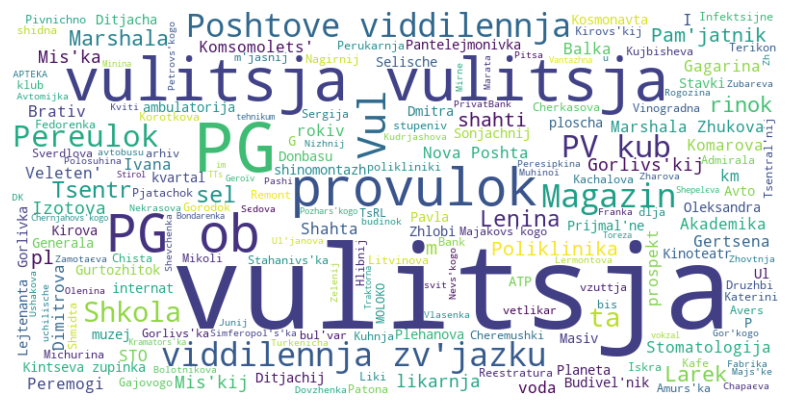

In [528]:
word_list = list(set(acled_gdf['COMBINED_PLACES'][9]))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(word_list))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Optionally save the word cloud to a file
# plt.savefig('word_cloud.png', dpi=300)

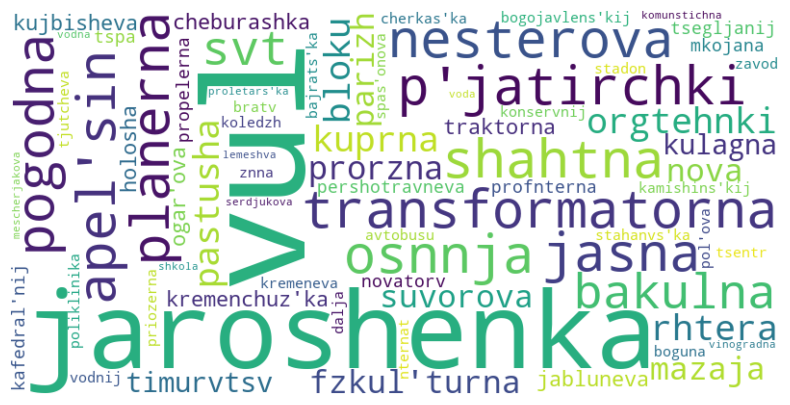

In [529]:
word_list = list(set(acled_gdf['CLEANED_PLACES'][9]))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(word_list))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Optionally save the word cloud to a file
# plt.savefig('word_cloud.png', dpi=300)

### Counting number of tweet matches to ACLED event for each rank

In [573]:
rank_2.head(2)

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90,MATCH_LOC,INDEX_LIST,DATE_LIST,RANK
0,"Odessa, Ukraine",[],[],1553893522058592256,2022-08-01,1,The one hundred and fifty-eighth day of the he...,"[{'text': 'Ukraine', 'indices': [123, 131]}, {...",,,...,,,,"['one', 'hundred', 'fiftyeighth', 'day', 'hero...","{'one': [776, 781, 279, 59, 192, 594, 480, 492...","{'one': [192, 480, 776, 492, 781, 594, 279, 76...",{'ukraine': [771]},"[192, 480, 776, 492, 781, 594, 279, 761, 59, 1...","[2022-08-05, 2022-08-02, 2022-08-03, 2022-08-1...",2
1,Oslo,[],[],1553893721627820033,2022-08-01,2,It remains to be seen if Ukraine has enough tr...,"[{'text': 'UkraineRussiaWar', 'indices': [119,...",,,...,,,,"['remains', 'seen', 'ukraine', 'enough', 'troo...","{'seen': [491], 'ukraine': [647], 'troops': [3...","{'troops': [355, 268, 846], 'weapons': [604, 6...",{'ukraine': [771]},"[355, 268, 846, 604, 605, 446, 131, 652, 142, ...","[2022-08-05, 2022-08-02, 2022-08-13, 2022-08-0...",2


In [574]:
rank_3.head(2)

,location,places,p_labels,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,DATE,...,QUANTITY,LAW,PERCENT,TEXT_PROCESSED,MATCH_CIW,MATCH_CIW_90,MATCH_LOC,DATE_LIST,RANK,INDEX_LIST
0,"Melbourne, Australia",[],[],1553893276297891840,2022-08-01,0,Owner of Ukraine's largest grain exporter kill...,"[{'text': 'UkraineInvasion', 'indices': [100, ...",,,...,,,,"['owner', 'ukraines', 'largest', 'grain', 'exp...","{'owner': [425, 686, 208, 753, 214, 762, 155],...","{'grain': [231], 'killed': [389, 392, 418, 432...",{},"[2022-08-05, 2022-08-02, 2022-08-13, 2022-08-0...",3,"[231, 389, 392, 418, 432, 181, 438, 442, 195, ..."
1,United States,['united states'],['GPE'],1553893346145435650,2022-08-01,1,Listen on SPOTIFY \n https://t.co/lHQO8PNNmL\n...,"[{'text': 'CR7𓃵', 'indices': [58, 63]}, {'text...",,[newmusicfriday],...,,,,"['listen', 'spotify', 'free', 'spotify', 'musi...",{'free': [52]},{'free': [52]},{},[2022-08-01],3,[52]


In [580]:
%%time
combined_list = []

# Iterate through each row in the DataFrame
for index, row in rank_2.iterrows():
    # Get the dictionary from the 'data_column' for each row
    data_list = row['INDEX_LIST']
    combined_list.extend(data_list)

Wall time: 1.63 s


In [581]:
# Create a Counter object to count the occurrences of each word in the list
id_freq_counter = Counter(combined_list)

# Get the most common words and their frequencies
most_common_ids = id_freq_counter.most_common()

id_freq = dict(most_common_ids)
id_freq

{250: 15391,
 251: 13238,
 249: 13237,
 451: 13236,
 254: 12221,
 252: 12219,
 253: 12219,
 100: 12075,
 237: 12060,
 234: 12045,
 753: 11695,
 280: 11683,
 425: 11682,
 228: 11550,
 241: 11370,
 248: 11330,
 245: 11322,
 230: 11283,
 259: 10525,
 492: 10494,
 263: 10469,
 265: 10468,
 260: 10467,
 262: 10467,
 239: 10349,
 452: 10047,
 666: 9729,
 684: 9728,
 244: 9699,
 247: 9695,
 243: 9695,
 246: 9695,
 232: 9656,
 115: 9233,
 397: 9028,
 358: 9028,
 365: 8707,
 781: 8489,
 776: 8484,
 761: 8214,
 471: 7984,
 689: 7895,
 483: 7686,
 81: 7595,
 383: 7506,
 762: 7469,
 621: 7312,
 759: 7085,
 438: 6799,
 594: 6717,
 740: 6694,
 752: 6694,
 87: 6672,
 279: 6663,
 6: 6652,
 90: 6562,
 5: 6561,
 86: 6560,
 686: 6541,
 751: 6439,
 630: 6428,
 830: 6329,
 817: 6327,
 835: 6326,
 213: 6241,
 404: 6210,
 475: 6203,
 595: 6176,
 758: 6094,
 389: 6092,
 757: 6092,
 622: 6069,
 226: 5986,
 23: 5963,
 22: 5961,
 24: 5952,
 36: 5952,
 37: 5949,
 431: 5933,
 482: 5857,
 738: 5837,
 663: 5728,
 65

In [582]:
%%time
combined_list = []

# Iterate through each row in the DataFrame
for index, row in rank_3.iterrows():
    # Get the dictionary from the 'data_column' for each row
    data_list = row['INDEX_LIST']
    combined_list.extend(data_list)

Wall time: 2.8 s


In [583]:
# Create a Counter object to count the occurrences of each word in the list
id_freq_counter = Counter(combined_list)

# Get the most common words and their frequencies
most_common_ids = id_freq_counter.most_common()

id_freq2 = dict(most_common_ids)
id_freq2

{250: 23249,
 251: 19695,
 249: 19693,
 451: 19692,
 228: 19511,
 100: 18750,
 254: 18714,
 252: 18712,
 253: 18712,
 237: 17966,
 234: 17951,
 280: 17527,
 241: 17326,
 492: 17113,
 248: 16576,
 245: 16562,
 753: 16556,
 425: 16516,
 230: 16464,
 383: 15945,
 265: 15831,
 263: 15829,
 260: 15828,
 262: 15827,
 259: 15801,
 239: 15319,
 438: 14757,
 452: 14676,
 594: 14610,
 761: 14607,
 781: 14296,
 776: 14295,
 115: 14251,
 759: 14206,
 244: 14046,
 247: 14039,
 243: 14037,
 246: 14037,
 666: 14009,
 684: 14008,
 213: 13912,
 595: 13791,
 389: 13672,
 757: 13672,
 758: 13667,
 751: 13626,
 471: 13600,
 232: 13590,
 740: 12789,
 752: 12789,
 689: 12784,
 365: 12582,
 397: 12462,
 358: 12462,
 87: 12115,
 461: 11936,
 483: 11816,
 279: 11805,
 621: 11718,
 418: 11637,
 81: 11626,
 630: 11519,
 762: 11390,
 738: 11357,
 431: 11101,
 622: 11023,
 174: 10795,
 385: 10794,
 384: 10541,
 430: 10528,
 379: 10386,
 482: 10328,
 6: 10238,
 36: 10146,
 24: 10143,
 37: 10136,
 23: 10123,
 22: 10

In [586]:
acled_to_csv['rank_2_count'] = acled_to_csv.index.to_series().map(id_freq).fillna(0)
acled_to_csv['rank_3_count'] = acled_to_csv.index.to_series().map(id_freq2).fillna(0)

In [587]:
acled_to_csv

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,...,LONGITUDE,GEO_PRECISION,SOURCE,SOURCE_SCALE,NOTES,FATALITIES,TIMESTAMP,MONTH,rank_2_count,rank_3_count
0,804,UKR66159,66159,2022-08-01,2022,1,Battles,Armed clash,NAF: United Armed Forces of Novorossiya,Donbass People's Militia; Military Forces of R...,...,38.009,1,Ministry of Defence of Ukraine; DPR Armed Forc...,Other,"On 1 August 2022, Russian forces shelled Zaits...",0,1660055880,8,3880,5936
1,804,UKR66219,66219,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Russia (2000-),None,...,36.253,1,24 Channel; Ministry of Defence of Ukraine,Other-National,"On 1 August 2022, Russian forces fired artille...",1,1660055880,8,4259,7847
2,804,UKR66494,66494,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Russia (2000-),None,...,32.018,1,Ministry of Defence of Ukraine; 24 Channel,Other-National,"On 1 August 2022, Russian forces shelled Mykol...",0,1660055880,8,1756,3466
3,804,UKR66904,66904,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Ukraine (2019-),None,...,38.132,1,DPR Armed Forces Press Service,Other,"On 1 August 2022, Ukrainian forces fired 120mm...",0,1660055880,8,2484,4367
4,804,UKR66905,66905,2022-08-01,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Ukraine (2019-),None,...,38.135,1,DPR Armed Forces Press Service,Other,"On 1 August 2022, Ukrainian forces fired 155mm...",0,1660055880,8,2482,4365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,804,UKR77828,77828,2022-08-15,2022,3,Violence against civilians,Attack,Military Forces of Russia (2000-),None,...,36.941,1,Kharkiv Human Rights Protection Group,Other,"Around 15 August 2022 (month of), Russian forc...",0,1667319407,8,988,1673
860,804,UKR78821,78821,2022-08-15,2022,3,Violence against civilians,Attack,Military Forces of Russia (2000-),None,...,37.248,1,HRW,Other,"Around 15 August 2022 (month of), Russian forc...",0,1667924775,8,2069,3500
861,804,UKR78820,78820,2022-08-15,2022,3,Violence against civilians,Attack,Military Forces of Russia (2000-),None,...,37.248,1,HRW,Other,"Around 15 August 2022 (month of), Russian forc...",1,1667924775,8,778,1371
862,804,UKR78669,78669,2022-08-15,2022,3,Violence against civilians,Abduction/forced disappearance,Military Forces of Russia (2000-),None,...,37.248,1,HRW,Other,"Around 15 August 2022 (month of), Russian forc...",0,1667924775,8,1178,2096


In [588]:
# Replace 'path_to_output_shapefile' with the desired path for your shapefile
acled_to_csv.to_csv(r'D:\PENNSTATE_GIS\CAPSTONE!\SHAPES\acled.csv', index=False)